# Aug ??st, 2021

**Motivation**: fig 2 <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
svinet_props = {
    'task': 'rest',
    'mode': 'bold',
    'metric': 'pearson',
    'match_metric': 'cosine',
    'graph_type': 'real',
}
mice = Mice(Config(128))
mice.combine_dfs(svinet_props.get('task', 'rest'), full=True)

k = 12
p = 20
svinet = SVINET(mice, k, p, 'sub-SLC')
group_dir = get_svinet_group_dir(
    results_dir=mice.cfg.results_dir,
    k=k,
    p=p,
    graph_type=svinet_props.get('graph_type', 'real'),
)
print(group_dir)

current expt: 'p20'

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/gr
oup_results/real-p20-k12

## Load group results

In [3]:
file = sorted(os.listdir(group_dir), key=sort_date_latest)[-1]
file

'group_(2021_08_23).npy'

In [4]:
group = np.load(pjoin(group_dir, file), allow_pickle=True).item()

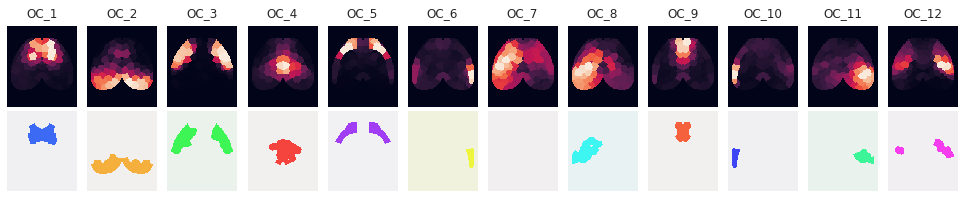

In [5]:
fig, axes = create_figure(2, k, (13.5, 2.8))
gam_arr = svinet.pi2arr(group['gam'], cortex_only=True)
masks = svinet.masks_from_pi(group['pi'], disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(k):
    im = axes[0, j].imshow(gam_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
plt.show()

<matplotlib.colorbar.Colorbar object at 0x7fc04f4dfb80>

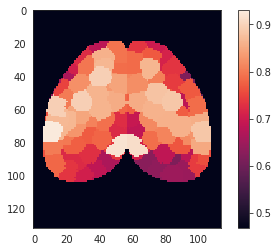

In [6]:
h = sp_stats.entropy(group['pi'], axis=0) / np.log(k)
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.colorbar()

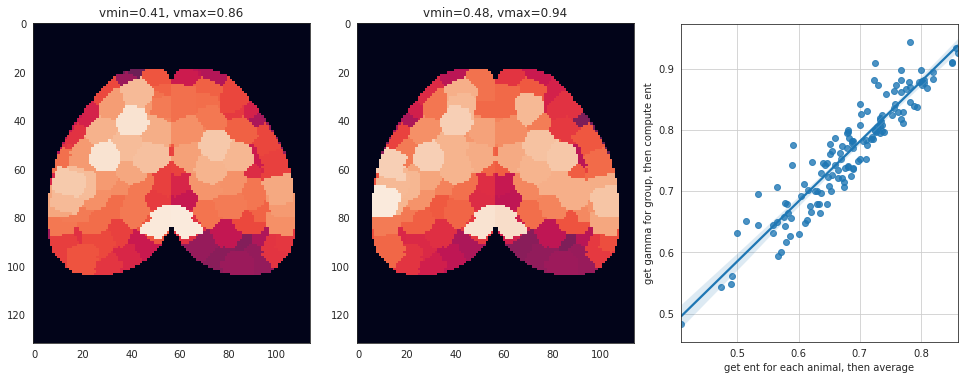

In [7]:
fig, axes = create_figure(1, 3, (13.5, 5.5))

a = np.nanmean(np.nanmean(group['gam_all'], 2), 1)
eh_avg = np.nanmean(entropy_expect_beta(a), 0)
mask = svinet.pi2arr(eh_avg.reshape(1, -1), cortex_only=True)[1]
axes[0].imshow(mask, vmin=np.min(eh_avg), vmax=np.max(eh_avg))
axes[0].set_title(f"vmin={np.min(eh_avg):.2f}, vmax={np.max(eh_avg):.2f}")

a = np.nanmean(np.nanmean(np.nanmean(group['gam_all'], 2), 1), 0)
eh_group = entropy_expect_beta(a)
mask = svinet.pi2arr(eh_group.reshape(1, -1), cortex_only=True)[1]
axes[1].imshow(mask, vmin=np.min(eh_group), vmax=np.max(eh_group))
axes[1].set_title(f"vmin={np.min(eh_group):.2f}, vmax={np.max(eh_group):.2f}")

sns.regplot(eh_avg, eh_group, ax=axes[2])
axes[2].set_xlabel('get ent for each animal, then average')
axes[2].set_ylabel('get gamma for group, then compute ent')
axes[2].set_aspect('equal')
axes[2].grid()

In [8]:
min(eh_avg), min(eh_group)

(0.4083235222627434, 0.4830984325645108)

In [9]:
max(eh_avg), max(eh_group)

(0.8597450999523846, 0.9434070286177424)

take aligned gammas, average them to get the overal gamma for animal/session.  Then estimate beta parameters for each community/node, and compare that distribution vs seed's distribution

just like pi_all, loop over keys and make gam_all which is also numpy array (rather than just a dict)

## BOOTSTRAP (light)

In [10]:
n = 1e4
pi_bca = np.load(pjoin(group_dir, f"pi_bca{n:1.0e}.npy"), allow_pickle=True).item()
pi_boot = np.load(pjoin(group_dir, f"pi_boot{n:1.0e}.npy"))
gam_boot = np.load(pjoin(group_dir, f"gam_boot{n:1.0e}.npy"))

statistic = get_statistic_fn(
    est_sub=np.nanmean,
    est_ses=np.nanmean,
    est_seed=np.nanmean,
)
pi_real = statistic(group['pi_all'])

<matplotlib.lines.Line2D object at 0x7fc04f5dbb50>

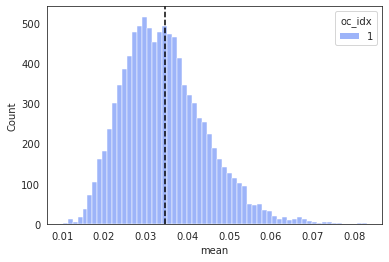

In [11]:
i = 0
j = 47

_df = pd.DataFrame({
    'oc_idx': [i + 1] * len(pi_boot),
    'node': [j] * len(pi_boot),
    'mean': pi_boot[:, i, j],
})
sns.histplot(
    data=_df,
    x='mean',
    hue='oc_idx',
    palette=svinet.colors,
)
plt.axvline(pi_real[i, j], color='k', ls='--')

In [168]:
pi_real[:, 47]

array([0.03451369, 0.23749419, 0.00329996, 0.14386792, 0.00842677,
       0.02732099, 0.10877627, 0.31329642, 0.01836491, 0.01636561,
       0.05638784, 0.03188542])

In [12]:
statistic = get_statistic_fn(
    est_sub=np.nanmean,
    est_ses=np.nanmean,
    est_seed=np.nanmean,
)
pi_real = statistic(group['pi_all'])
pi_real.shape

(12, 138)

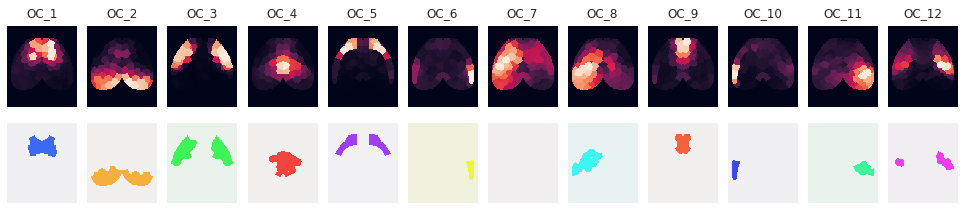

In [13]:
fig, axes = create_figure(2, k, (13.5, 3.2))
pi_arr = svinet.pi2arr(pi_real, cortex_only=True)
masks = svinet.masks_from_pi(pi_real, disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(k):
    im = axes[0, j].imshow(pi_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
plt.show()

In [14]:
pi_arr = svinet.pi2arr(pi_real, cortex_only=True)
x = np.zeros((len(svinet.n2l), *pi_arr[-1].shape))
for node in svinet.n2l:
    for i in range(k):
        x[node] += pi_real[i, node] * pi_arr[i + 1]
mask_nonzero = np.abs(x).astype(bool).sum(0).astype(bool)
x_list = filter_boundaries([x[i] for i in range(len(x))], mask_nonzero)
x = np.concatenate([e[np.newaxis, ...] for e in x_list])
x.shape

(138, 85, 102)

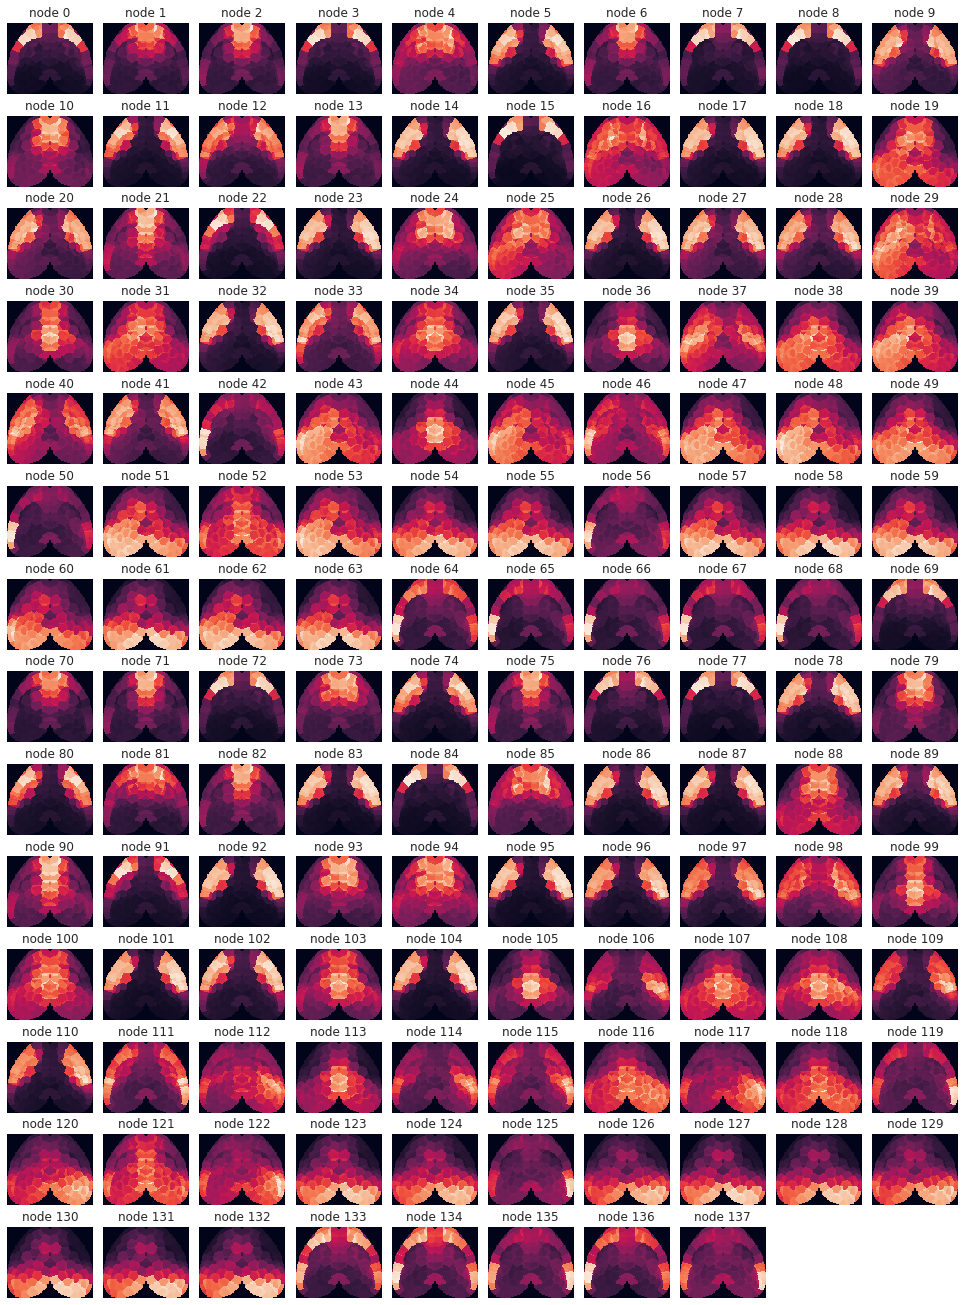

In [15]:
nrows = 14
ncols = int(np.ceil(len(x) / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 1.3 * nrows))
for i, ax in zip(range(len(x)), axes.ravel()):
    ax.imshow(x[i])
    ax.set_title(f"node {i}")
trim_axs(axes, len(x))
remove_ticks(axes)
plt.show()

In [40]:
x.shape

(138, 85, 102)

In [98]:
from sklearn.decomposition import PCA

In [101]:
pca = PCA(n_components=7, svd_solver='full').fit(x.reshape(len(x), -1))
comps = pca.components_.reshape((-1, *x.shape[1:])).copy()
comps.shape

(7, 85, 102)

<matplotlib.lines.Line2D object at 0x7fc02f2282b0>

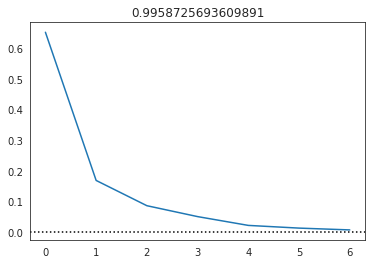

In [102]:
plt.plot(pca.explained_variance_ratio_)
plt.title(pca.explained_variance_ratio_.sum())
plt.axhline(0, ls=':', color='k')

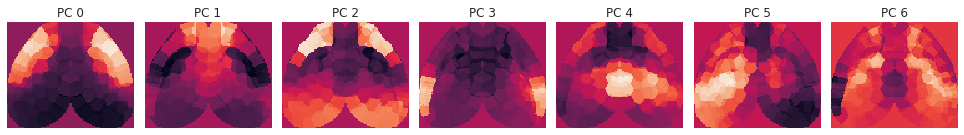

In [103]:
nrows = 1
ncols = int(np.ceil(len(comps) / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 2.2 * nrows))
for i, ax in zip(range(len(x)), axes.ravel()):
    ax.imshow(comps[i])
    ax.set_title(f"PC {i}")
trim_axs(axes, len(comps))
remove_ticks(axes)
plt.show()

In [516]:
core_id = 120
xx = [f"{i:03d}" for i in range(320)]
get_rng().shuffle(xx)
sorted(xx)

[
    '000',
    '001',
    '002',
    '003',
    '004',
    '005',
    '006',
    '007',
    '008',
    '009',
    '010',
    '011',
    '012',
    '013',
    '014',
    '015',
    '016',
    '017',
    '018',
    '019',
    '020',
    '021',
    '022',
    '023',
    '024',
    '025',
    '026',
    '027',
    '028',
    '029',
    '030',
    '031',
    '032',
    '033',
    '034',
    '035',
    '036',
    '037',
    '038',
    '039',
    '040',
    '041',
    '042',
    '043',
    '044',
    '045',
    '046',
    '047',
    '048',
    '049',
    '050',
    '051',
    '052',
    '053',
    '054',
    '055',
    '056',
    '057',
    '058',
    '059',
    '060',
    '061',
    '062',
    '063',
    '064',
    '065',
    '066',
    '067',
    '068',
    '069',
    '070',
    '071',
    '072',
    '073',
    '074',
    '075',
    '076',
    '077',
    '078',
    '079',
    '080',
    '081',
    '082',
    '083',
    '084',
    '085',
    '086',
    '087',
    '088',
    '089',
    '090',
    '091',
    '092',
    '093',
    '094',
    '095',
    '096',
    '097',
    '098',
    '099',
    '100',
    '101',
    '102',
    '103',
    '104',
    '105',
    '106',
    '107',
    '108',
    '109',
    '110',
    '111',
    '112',
    '113',
    '114',
    '115',
    '116',
    '117',
    '118',
    '119',
    '120',
    '121',
    '122',
    '123',
    '124',
    '125',
    '126',
    '127',
    '128',
    '129',
    '130',
    '131',
    '132',
    '133',
    '134',
    '135',
    '136',
    '137',
    '138',
    '139',
    '140',
    '141',
    '142',
    '143',
    '144',
    '145',
    '146',
    '147',
    '148',
    '149',
    '150',
    '151',
    '152',
    '153',
    '154',
    '155',
    '156',
    '157',
    '158',
    '159',
    '160',
    '161',
    '162',
    '163',
    '164',
    '165',
    '166',
    '167',
    '168',
    '169',
    '170',
    '171',
    '172',
    '173',
    '174',
    '175',
    '176',
    '177',
    '178',
    '179',
    '180',
    '181',
    '182',
    '183',
    '184',
    '185',
    '186',
    '187',
    '188',
    '189',
    '190',
    '191',
    '192',
    '193',
    '194',
    '195',
    '196',
    '197',
    '198',
    '199',
    '200',
    '201',
    '202',
    '203',
    '204',
    '205',
    '206',
    '207',
    '208',
    '209',
    '210',
    '211',
    '212',
    '213',
    '214',
    '215',
    '216',
    '217',
    '218',
    '219',
    '220',
    '221',
    '222',
    '223',
    '224',
    '225',
    '226',
    '227',
    '228',
    '229',
    '230',
    '231',
    '232',
    '233',
    '234',
    '235',
    '236',
    '237',
    '238',
    '239',
    '240',
    '241',
    '242',
    '243',
    '244',
    '245',
    '246',
    '247',
    '248',
    '249',
    '250',
    '251',
    '252',
    '253',
    '254',
    '255',
    '256',
    '257',
    '258',
    '259',
    '260',
    '261',
    '262',
    '263',
    '264',
    '265',
    '266',
    '267',
    '268',
    '269',
    '270',
    '271',
    '272',
    '273',
    '274',
    '275',
    '276',
    '277',
    '278',
    '279',
    '280',
    '281',
    '282',
    '283',
    '284',
    '285',
    '286',
    '287',
    '288',
    '289',
    '290',
    '291',
    '292',
    '293',
    '294',
    '295',
    '296',
    '297',
    '298',
    '299',
    '300',
    '301',
    '302',
    '303',
    '304',
    '305',
    '306',
    '307',
    '308',
    '309',
    '310',
    '311',
    '312',
    '313',
    '314',
    '315',
    '316',
    '317',
    '318',
    '319'
]

In [520]:
n_loop = 120
n_boot = 1e5



'boot-1.2e+07'

In [128]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=6).fit(x.reshape(len(x), -1))
comps = km.cluster_centers_.reshape((-1, *x.shape[1:])).copy()
comps.shape

(6, 85, 102)

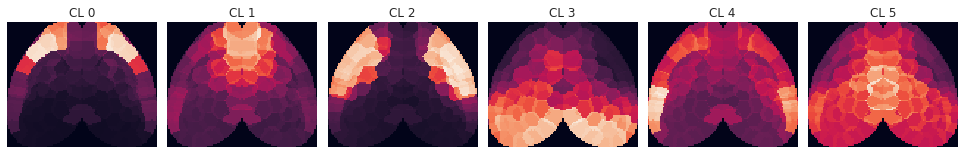

In [129]:
nrows = 1
ncols = int(np.ceil(len(comps) / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 2.2 * nrows))
for i, ax in zip(range(len(x)), axes.ravel()):
    ax.imshow(comps[i])
    ax.set_title(f"CL {i}")
trim_axs(axes, len(comps))
remove_ticks(axes)
plt.show()

In [131]:
y = pi_real.T @ pi_real
y.shape

(138, 138)

<matplotlib.colorbar.Colorbar object at 0x7fc02cea6070>

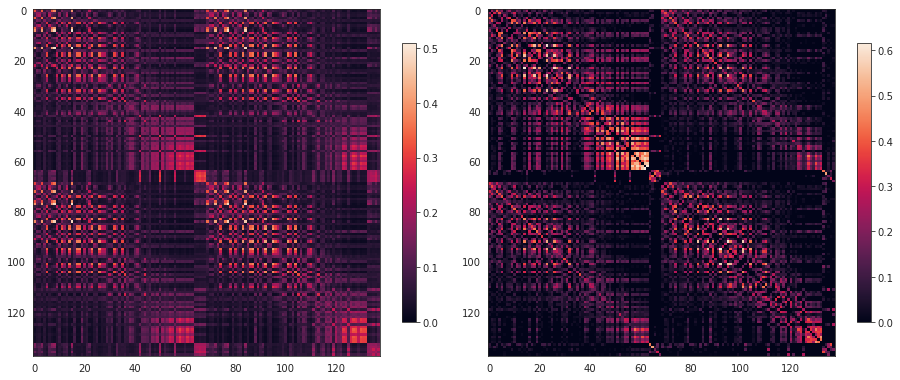

In [155]:
fig, axes = create_figure(1, 2, (13, 10))

im = axes[0].imshow(y, vmin=0)
plt.colorbar(im, ax=axes[0], shrink=0.4)

im = axes[1].imshow(svinet.adjacencies[66], vmin=0)
plt.colorbar(im, ax=axes[1], shrink=0.4)

In [156]:
np.diag(y)

array([0.32437064, 0.18929639, 0.22754221, 0.34523866, 0.16019137,
       0.27991366, 0.24284525, 0.35538588, 0.47980049, 0.20537885,
       0.19104859, 0.28300114, 0.14485044, 0.23543487, 0.33989463,
       0.50932897, 0.12447585, 0.33904298, 0.34213202, 0.15311389,
       0.18174896, 0.17656234, 0.21849916, 0.34090935, 0.18778185,
       0.1478698 , 0.35857526, 0.18802132, 0.18123815, 0.13148062,
       0.21061064, 0.1420285 , 0.2879783 , 0.13487697, 0.14964168,
       0.2430536 , 0.28717052, 0.15545826, 0.18023498, 0.18100936,
       0.14284013, 0.14452845, 0.25506156, 0.17169215, 0.25370448,
       0.14972725, 0.11146637, 0.1939093 , 0.185696  , 0.18541454,
       0.29118677, 0.19689557, 0.11605896, 0.18219038, 0.22985107,
       0.22838862, 0.2139843 , 0.23998769, 0.29539988, 0.23893932,
       0.19405439, 0.27919277, 0.23148437, 0.25556743, 0.22663175,
       0.29861451, 0.32258257, 0.28084615, 0.31838837, 0.28833587,
       0.22213904, 0.27092677, 0.37321021, 0.22198206, 0.28719935,
       0.22722721, 0.31137704, 0.48575282, 0.29114377, 0.22008225,
       0.25418069, 0.15240866, 0.23375047, 0.38751287, 0.46404402,
       0.20455735, 0.33924328, 0.39224466, 0.16163789, 0.25046899,
       0.19043337, 0.21590613, 0.41531598, 0.21245083, 0.14378085,
       0.41241256, 0.28381765, 0.20758504, 0.13231977, 0.21721151,
       0.14524787, 0.37181118, 0.21570429, 0.15595794, 0.34796908,
       0.31443388, 0.21662601, 0.17473179, 0.1588885 , 0.22545071,
       0.23844942, 0.15761459, 0.15518347, 0.27828439, 0.1653917 ,
       0.1329191 , 0.17119553, 0.18683144, 0.17489723, 0.24338304,
       0.20901609, 0.11997832, 0.15599941, 0.26345079, 0.2505547 ,
       0.2450412 , 0.26200928, 0.33472652, 0.31712575, 0.21455769,
       0.32007814, 0.3005058 , 0.30162615, 0.18062162, 0.1976864 ,
       0.25514888, 0.20878094, 0.22878246])

<matplotlib.lines.Line2D object at 0x7fc02ccbfe50>

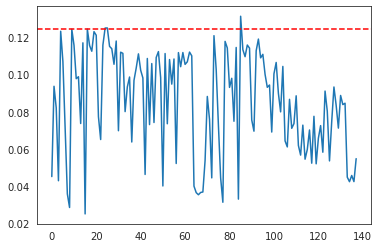

In [165]:
i = 16
plt.plot(y[i])
plt.axhline(y[i, i], color='r', ls='--')

In [169]:
d = sp_dist.cdist(y, svinet.adjacencies[66], metric='cosine')
s = dist2sim(d)

<AxesSubplot:>

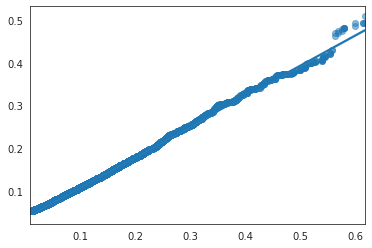

In [172]:
a = svinet.adjacencies[66].ravel()
sns.regplot(sorted(a)[-11534:], sorted(y.ravel())[-11534:], scatter_kws={'alpha': 0.5})

In [493]:
y = pi_real.T @ pi_real
y.shape

(138, 138)

In [494]:
from sklearn.cluster import KMeans

n_clusters = 6
km = KMeans(n_clusters=n_clusters, random_state=mice.cfg.random_state).fit(y)
comps = km.cluster_centers_.copy()
comps /= comps.sum(0, keepdims=True)
gmap = align_centroid_to_structs(
    struct_ids=svinet.struct_ids[:n_clusters],
    masks_mv=svinet.masks_from_pi(comps, disjoint=True, cortex_only=True),
    dist_metric='dice',
    global_order=True,
    allen=mice.allen,
)[:n_clusters]
comps = comps[gmap]
comps.shape

(6, 138)

In [495]:
comps_vol = svinet.to_vol(comps, cortex_only=True)
comps_2d = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in comps_vol.items()
}

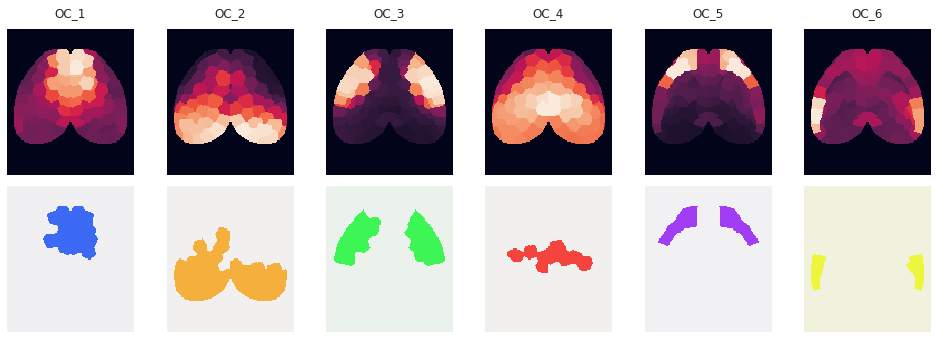

In [496]:
fig, axes = create_figure(2, len(comps), (13.5, 4.8))
pi_arr = svinet.pi2arr(comps, cortex_only=True)
masks = svinet.masks_from_pi(comps, disjoint=True, cortex_only=True)
disjoint_arr = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in masks.items()
}
for j in range(len(comps)):
    im = axes[0, j].imshow(pi_arr[j + 1], cmap='rocket', vmin=0)
    _ = axes[1, j].imshow(disjoint_arr[j + 1], cmap=svinet.cmaps[j + 1])
    axes[0, j].set_title(f"OC_{j + 1}", y=1.04)
remove_ticks(axes)
plt.show()

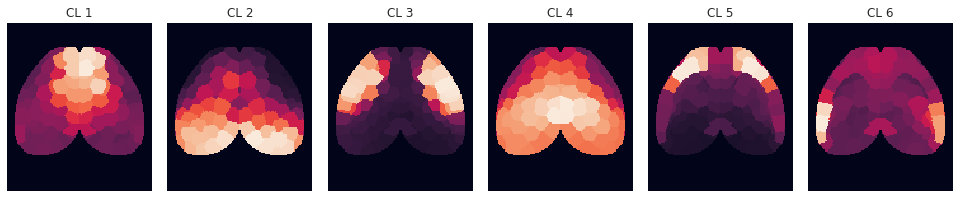

In [497]:
nrows = 1
ncols = int(np.ceil(len(comps_2d) / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 2.7 * nrows))
for i, ax in zip(range(len(x)), axes.ravel()):
    ax.imshow(comps_2d[i+1])
    ax.set_title(f"CL {i+1}")
trim_axs(axes, len(comps))
remove_ticks(axes)
plt.show()

<matplotlib.colorbar.Colorbar object at 0x7fc0457dec10>

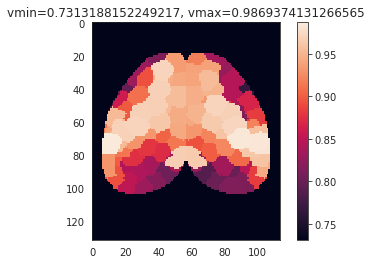

In [499]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.title(f"vmin={min(h)}, vmax={max(h)}")
plt.colorbar()

In [500]:
def map2interval(
    x: np.ndarray,
    interval: Tuple[float, float] = (0., 1.), ):
    
    a = interval[1] / (np.max(x) - np.min(x))
    b = - a * np.min(x)
    
    return a * x + b

<matplotlib.colorbar.Colorbar object at 0x7fbfe02ac580>

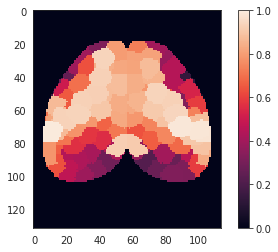

In [501]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
h = map2interval(h)
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.colorbar()

<AxesSubplot:ylabel='Count'>

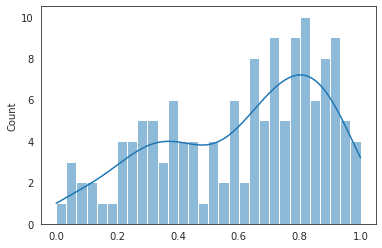

In [502]:
sns.histplot(h, bins=30, kde=True)

In [503]:
from sklearn.manifold import TSNE
y_emb = TSNE(
    n_components=2,
    perplexity=30,
    random_state=mice.cfg.random_state,
).fit_transform(y.reshape(len(y), -1))

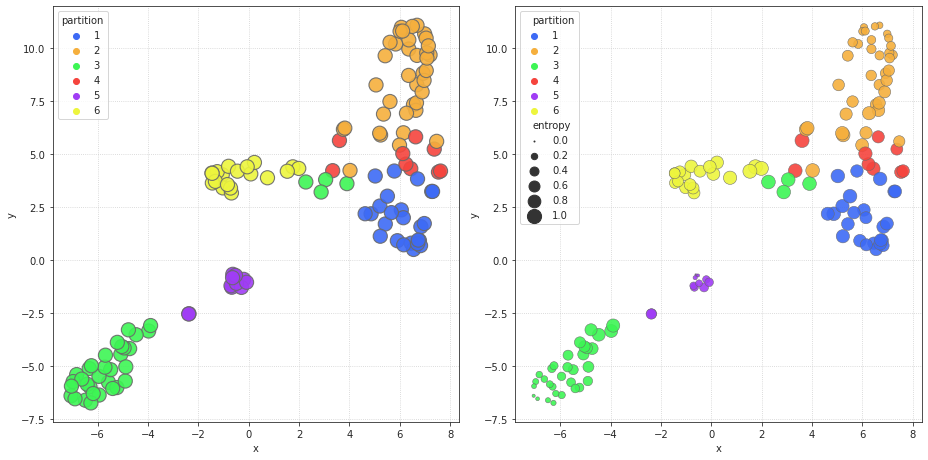

In [504]:
fig, axes = create_figure(1, 2, (13, 6.5), 'ticks')

_df = pd.DataFrame({
    'x': y_emb[:, 0],
    'y': y_emb[:, 1],
    'partition': 1 + np.argmax(comps, axis=0),
    'entropy': h,
})
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    palette=svinet.colors,
    s=200,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[0],
)
sns.scatterplot(
    data=_df,
    x='x',
    y='y',
    hue='partition',
    size='entropy',
    sizes=(1, 200),
    palette=svinet.colors,
    edgecolor='dimgrey',
    alpha=0.9,
    ax=axes[1],
)

for ax in axes.ravel():
    ax.grid(ls=':')
plt.show()

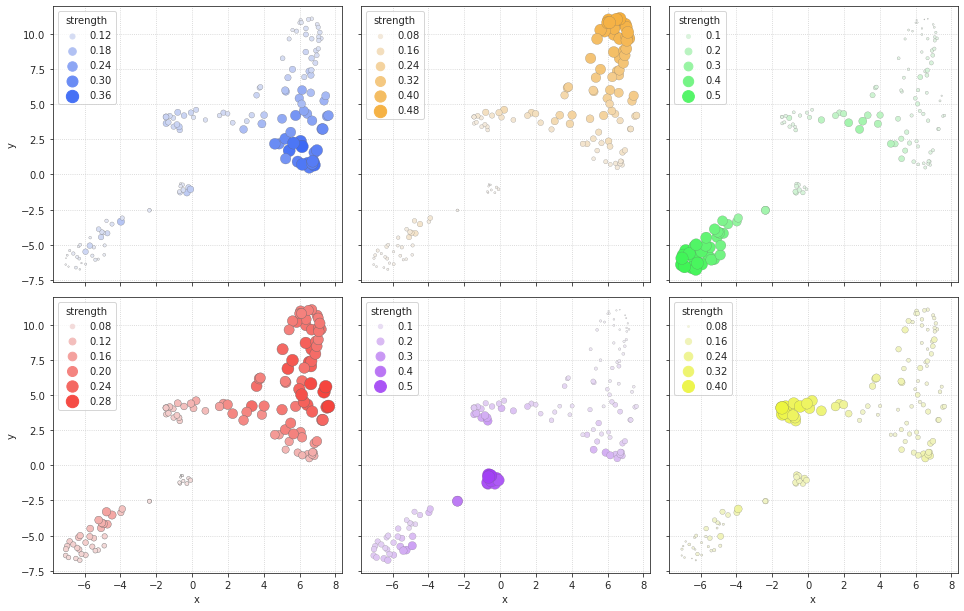

In [505]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'strength': comps[i, :],
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='strength',
        sizes=(1, 160),
        palette=svinet.cmaps[i+1],
        s=120,
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.grid(ls=':')
plt.show()

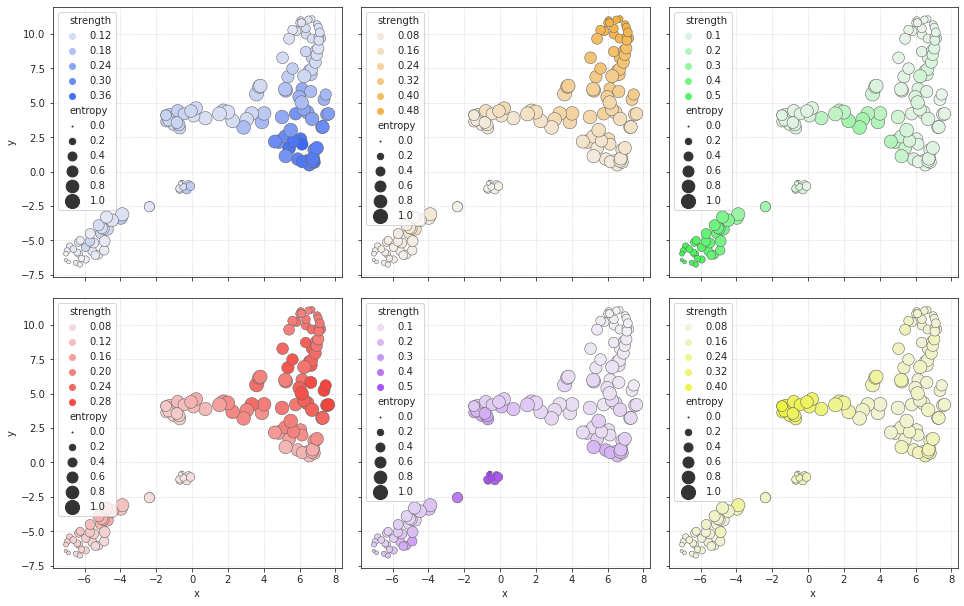

In [506]:
nrows = 2
ncols = int(np.ceil(n_clusters / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 4.3 * nrows), 'ticks', 'all', 'all')

for i, ax in enumerate(axes.ravel()):
    _df = pd.DataFrame({
        'x': y_emb[:, 0],
        'y': y_emb[:, 1],
        'strength': comps[i, :],
        'entropy': h,
    })
    sns.scatterplot(
        data=_df,
        x='x',
        y='y',
        hue='strength',
        size='entropy',
        sizes=(1, 200),
        palette=svinet.cmaps[i+1],
        edgecolor='dimgrey',
        ax=ax,
    )
    ax.grid(ls=':')
plt.show()

<AxesSubplot:>

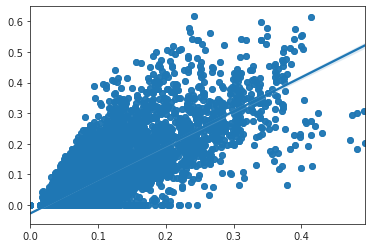

In [487]:
a = y.copy()
np.fill_diagonal(a, 0.)
a = a.ravel()
b = svinet.adjacencies[66].ravel()
sns.regplot(x=a, y=b)

In [509]:
from joblib import Parallel, delayed
_ = Parallel(n_jobs=2)(delayed(np.sqrt)(i ** 2) for i in range(100000))

In [ ]:
Parallel()

In [265]:
y2 = svinet.adjacencies[66]

In [266]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=7).fit(y2.reshape(len(y2), -1))
comps = km.cluster_centers_.reshape((-1, *y2.shape[1:])).copy()
comps /= comps.sum(0, keepdims=True)
comps.shape

(7, 138)

In [268]:
comps_vol = svinet.to_vol(comps, cortex_only=True)
comps_2d = {
    idx: project_vol_2d(m, mice.allen['dims_flat'], 'max_proj')
    for idx, m in comps_vol.items()
}

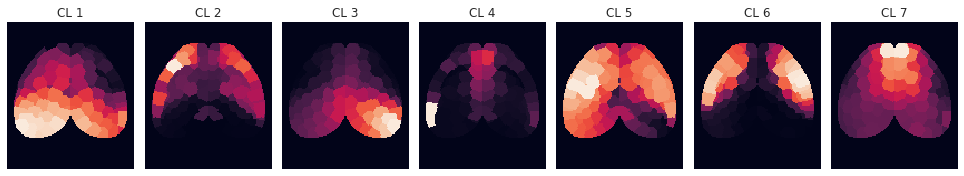

In [269]:
nrows = 1
ncols = int(np.ceil(len(comps_2d) / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 2.7 * nrows))
for i, ax in zip(range(len(x)), axes.ravel()):
    ax.imshow(comps_2d[i+1])
    ax.set_title(f"CL {i+1}")
trim_axs(axes, len(comps))
remove_ticks(axes)
plt.show()

<matplotlib.colorbar.Colorbar object at 0x7fbfdb7e7a60>

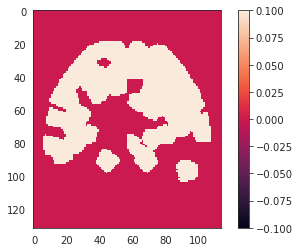

In [262]:
h = sp_stats.entropy(comps, axis=0) / np.log(len(comps))
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.colorbar()

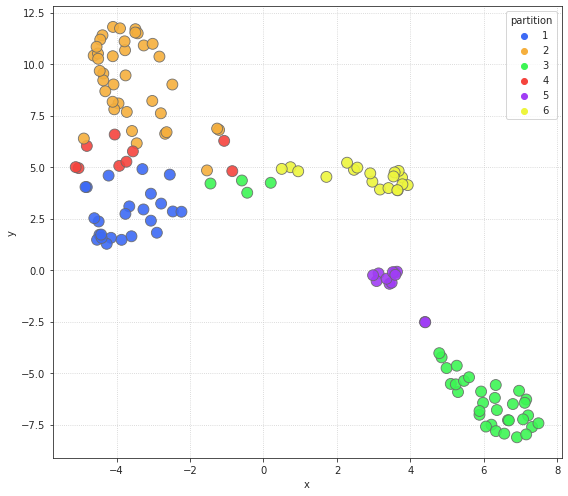

In [535]:
a = get_svinet_group_dir(mice.cfg.results_dir, 5, p, 'real')

In [538]:
x.shape

(800, 5, 138)

<AxesSubplot:ylabel='Density'>

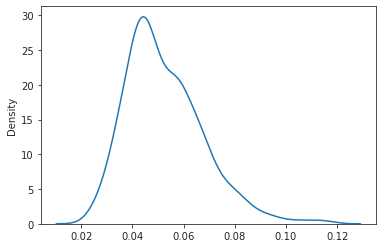

In [548]:
sns.kdeplot(x[:, 4, 16])

In [549]:
list(group)

[
    'gamma_all',
    'gam',
    'pi',
    'gam_all',
    'pi_all',
    'h_all',
    'cut_h',
    'cut_oc',
    'cut_nodes',
    'intervals'
]

In [553]:
group['gam_all'].shape, group['pi_all'].shape, group['h_all'].shape

((10, 3, 771, 12, 138), (10, 3, 771, 12, 138), (10, 3, 771, 138))

In [556]:
try:
    shutil.rmtree(pjoin(a, 'tmp'))
except FileNotFoundError:
    pass

<matplotlib.colorbar.Colorbar object at 0x7fc0457efe20>

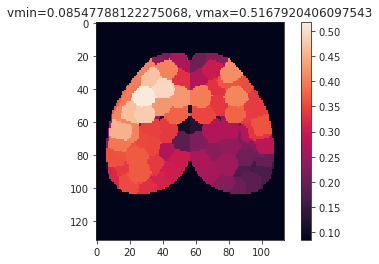

In [561]:
h = np.nanmean(np.nanmean(np.nanmean(group['h_all'], 2), 1), 0)

mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.title(f"vmin={min(h)}, vmax={max(h)}")
plt.colorbar()

In [562]:
pi_boot.shape

(10000, 12, 138)

In [565]:
np.where(np.isnan(pi_boot))

(
    array([   0,    0,    0, ..., 9999, 9999, 9999]),
    array([ 0,  0,  0, ..., 11, 11, 11]),
    array([  7,  22,  34, ..., 118, 120, 124])
)

In [566]:
x = np.load(pjoin(a, 'pi_boot-8.0e+02.npy'))

In [567]:
np.isnan(x).sum()

0

In [568]:
x.shape

(800, 5, 138)

In [573]:
h_boot = sp_stats.entropy(x.astype(float), axis=1) / np.log(5)
h_boot.shape

(800, 138)

<matplotlib.lines.Line2D object at 0x7fbfa8256c10>

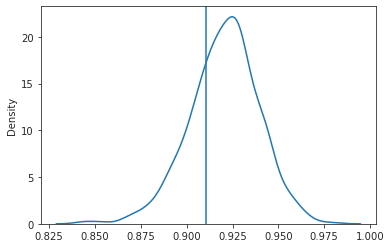

In [576]:
a = np.nanmean(np.nanmean(np.nanmean(group['gam_all'], 2), 1), 0)
eh = entropy_expect_beta(a)

sns.kdeplot(h_boot[:, 16])
plt.axvline(eh[16])

In [599]:
xxx = np.random.rand(1000, 1000, 1000)

def ff(w):
    a = np.nanmean(w, axis=1)
    return

def gg(w):
    a = np.mean(w, axis=1)
    return

In [600]:
%timeit ff(xxx)

7.19 s ± 37.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [601]:
%timeit gg(xxx)

690 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [593]:
yy = np.nanmean(xxx, axis=1);

In [ ]:
from fitter import Fitter

In [ ]:
f = Fitter(pi_boot[:, i, j], xmin=0, xmax=1, distributions=['beta', 't'], bins=100)
f.fit()

In [ ]:
f.summary()

In [ ]:
f.fitted_param['beta']

In [ ]:
rv, pdf = make_pdf('beta', f.fitted_param['beta'])

In [ ]:
rv.expect(func=lambda x: - x * np.log(x), lb=rv.ppf(0.0000001), ub=rv.ppf(0.9999999))

In [ ]:
rv.mean(), rv.expect(func=lambda x: x), pi_real[i, j]

In [ ]:
_g = group['gam'][:, j].copy()
_g[i], sum(_g), _g[i] / sum(_g)

In [ ]:
a, b, loc, scale = sp_stats.beta.fit(data=pi_boot[:, i, j], floc=1e-15, fscale=1.0)
rv_fit, pdf = make_pdf('beta', (a, b, loc, scale))
print(rv_fit.mean())
a, b, loc, scale

In [19]:
rv = sp_stats.beta(_g[i], sum(_g) - _g[i])
print(rv.mean())

x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 10000)

0.13079905338479683

<matplotlib.legend.Legend object at 0x7f5067fa5cd0>

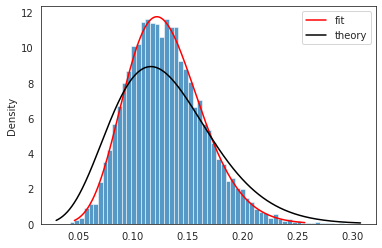

In [20]:
sns.histplot(pi_boot[:, i, j], stat='density')
plt.plot(pdf.index, pdf.values, color='r', label='fit')
plt.plot(x, rv.pdf(x), color='k', label='theory')
plt.legend()

In [21]:
rng = get_rng()
means = []
for _ in tqdm(range(100000)):
    samples = rng.beta(_g[i], sum(_g) - _g[i], size=10)
    means.append(np.mean(samples))

  0%|          | 0/100000 [00:00<?, ?it/s]

<AxesSubplot:ylabel='Count'>

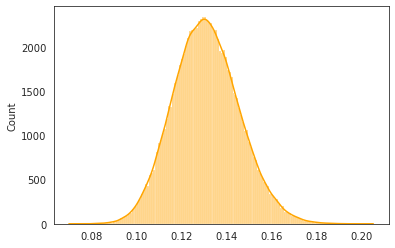

In [22]:
sns.histplot(means, color='orange', kde=True, alpha=0.5, label='sample means')

<matplotlib.legend.Legend object at 0x7f501864b970>

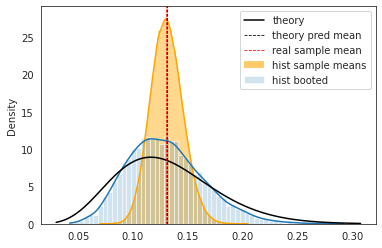

In [23]:
sns.histplot(means, color='orange', kde=True, stat='density', alpha=0.6, label='hist sample means')
sns.histplot(pi_boot[:, i, j], kde=True, stat='density', alpha=0.2, label='hist booted')
#plt.plot(pdf.index, pdf.values, color='r', label='fit')
plt.plot(x, rv.pdf(x), color='k', label='theory')
plt.axvline(rv.mean(), color='k', ls='--', lw=0.8, label='theory pred mean')
plt.axvline(pi_real[i, j], color='r', ls='--', lw=0.8, label='real sample mean')
plt.legend()

In [24]:
a = np.nanmean(np.nanmean(group['gam_all'], axis=2), axis=1)
ent_expect = entropy_expect_beta(a)
ent_expect.shape

(10, 138)

In [25]:
ent_dumb = sp_stats.entropy(group['gam'], axis=0) / np.log(k)

<AxesSubplot:>

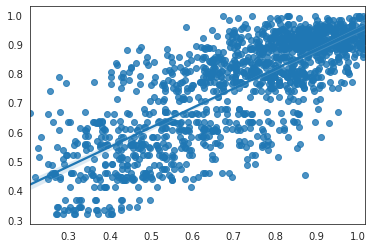

In [26]:
sns.regplot(ent_expect.ravel(), np.tile(ent_dumb, 10))

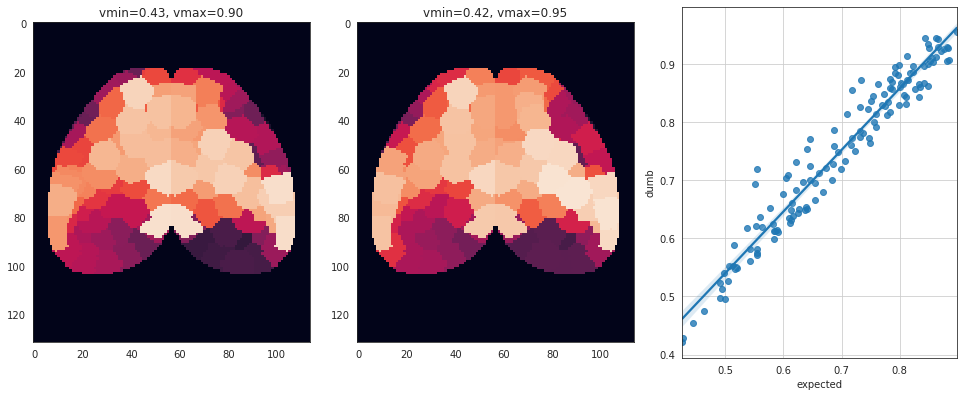

In [12]:
fig, axes = create_figure(1, 3, (13.5, 5.5))

a = np.nanmean(np.nanmean(group['gam_all'], 2), 1)
eh_avg = np.nanmean(entropy_expect_beta(a), 0)
mask = svinet.pi2arr(eh_avg.reshape(1, -1), cortex_only=True)[1]
axes[0].imshow(mask, vmin=np.min(eh_avg), vmax=np.max(eh_avg))
axes[0].set_title(f"vmin={np.min(eh_avg):.2f}, vmax={np.max(eh_avg):.2f}")


ent_dumb = sp_stats.entropy(group['gam'], axis=0) / np.log(k)
_h = ent_dumb
mask = svinet.pi2arr(_h.reshape(1, -1), cortex_only=True)[1]
axes[1].imshow(mask, vmin=np.min(_h), vmax=np.max(_h))
axes[1].set_title(f"vmin={np.min(_h):.2f}, vmax={np.max(_h):.2f}")


sns.regplot(eh_avg, _h, ax=axes[2])
axes[2].set_xlabel('expected')
axes[2].set_ylabel('dumb')
axes[2].set_aspect('equal')
axes[2].grid()

In [28]:
dist2sim(sp_dist.cosine(_h1[svinet.l_ids], _h1[svinet.r_ids]))

0.9882314043066642

In [29]:
dist2sim(sp_dist.cosine(_h[svinet.l_ids], _h[svinet.r_ids]))

0.9833516780437876

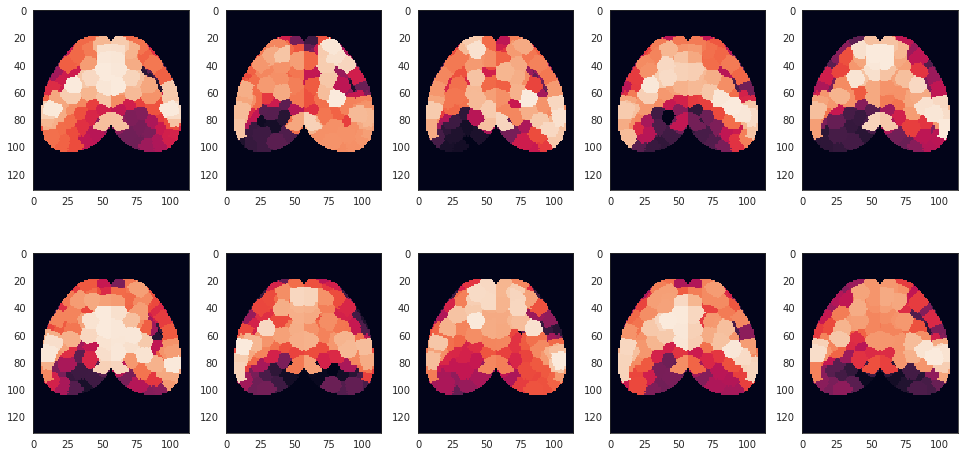

In [30]:
fig, axes = create_figure(2, 5, (13.5, 7))

for i, ax in enumerate(axes.ravel()):
    _h = ent_expect[i]
    mask = svinet.pi2arr(_h.reshape(1, -1), cortex_only=True)[1]
    ax.imshow(mask, vmin=min(_h), vmax=max(_h))

In [31]:
ent_expect.shape

(10, 138)

In [32]:
ehr = sp_stats.rankdata(ent_expect, axis=0)
ehr.shape

(10, 138)

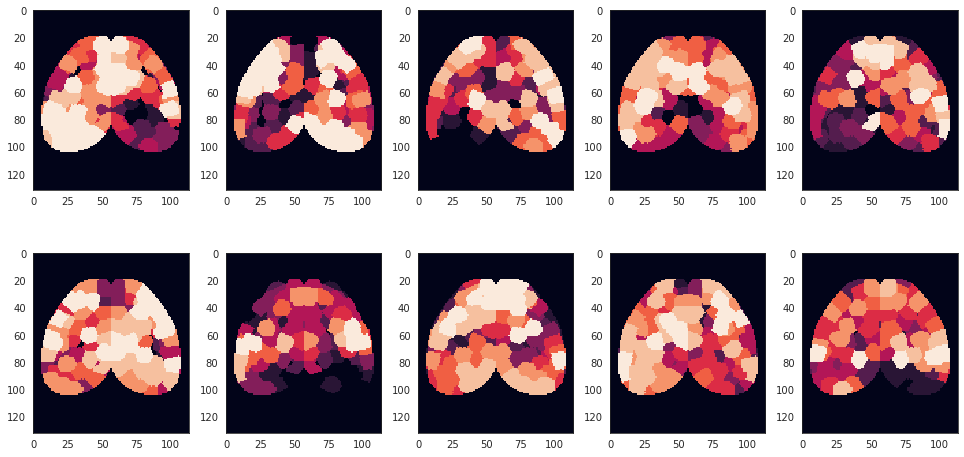

In [33]:
fig, axes = create_figure(2, 5, (13.5, 7))

for i, ax in enumerate(axes.ravel()):
    _h = ehr[i]
    mask = svinet.pi2arr(_h.reshape(1, -1), cortex_only=True)[1]
    ax.imshow(mask, vmin=min(_h), vmax=max(_h))

In [12]:
eh = entropy_expect_beta(np.nanmean(np.nanmean(group['gam_all'], 2), 1))
ehr = sp_stats.rankdata(eh, method='ordinal', axis=1)
q1, q2, q3 = np.nanquantile(eh, [0.25, 0.5, 0.75], axis=1)

num = eh.shape[1]

dlist = []
for i in range(len(eh)):
    labels = np.array(['na'] * num)
    labels[np.where(
        eh[i] < q1[i]
    )[0]] = 'Q0'
    labels[np.where(
        (q1[i] < eh[i]) &
        (eh[i] < q2[i])
    )[0]] = 'Q1'
    labels[np.where(
        (q2[i] < eh[i]) &
        (eh[i] < q3[i])
    )[0]] = 'Q2'
    labels[np.where(
        q3[i] < eh[i]
    )[0]] = 'Q3'
    dlist.append({
        'subject': [i] * num,
        'node': range(num),
        'rank': sp_stats.rankdata(eh[i]),
        'h': eh[i],
        'lbl': labels,
        })
df_h = pd.DataFrame(merge_dicts(dlist))

<seaborn.axisgrid.FacetGrid object at 0x7f8c2dc5f5e0>

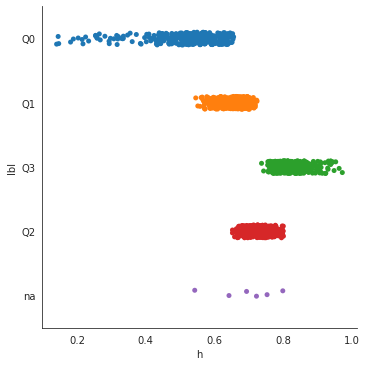

In [13]:
sns.catplot(
    data=df_h,
    x='h',
    y='lbl',
)

In [14]:
lbls = sorted(df_h.lbl.unique())
lbls.remove('na')
node_results = {}
for node in df_h.node.unique():
    _df = df_h.loc[df_h.node == node]
    counts = dict(collections.Counter(_df.lbl))
    counts = {
        lbl: counts.get(lbl, 0)
        for lbl in lbls
    }
    counts_coarse = {
        'ENT-L': (counts['Q0'] + counts['Q1']) / sum(counts.values()),
        'ENT-M': (counts['Q1'] + counts['Q2']) / sum(counts.values()),
        'ENT-H': (counts['Q2'] + counts['Q3']) / sum(counts.values()),
    }
    node_results[node] = (_df.h.mean(), _df.h.median(), _df.h.values, counts, counts_coarse)

In [15]:
node_results

{
    0: (
        0.5342536016722346,
        0.5463041944440621,
        array([0.25395437, 0.77334398, 0.46315969, 0.50403374, 0.33293566,
       0.62988065, 0.67323439, 0.71282102, 0.41059787, 0.58857465]),
        {'Q0': 7, 'Q1': 1, 'Q2': 2, 'Q3': 0},
        {'ENT-L': 0.8, 'ENT-M': 0.3, 'ENT-H': 0.2}
    ),
    1: (
        0.6999890967200617,
        0.6733891859539749,
        array([0.64876902, 0.6659302 , 0.7114716 , 0.67044846, 0.9092072 ,
       0.64289321, 0.70216243, 0.67632992, 0.65983153, 0.71284742]),
        {'Q0': 1, 'Q1': 4, 'Q2': 4, 'Q3': 1},
        {'ENT-L': 0.5, 'ENT-M': 0.8, 'ENT-H': 0.5}
    ),
    2: (
        0.6786486773450526,
        0.644951756130685,
        array([0.7907611 , 0.68597493, 0.63880773, 0.64684457, 0.8796024 ,
       0.57342983, 0.7192925 , 0.57317422, 0.63554055, 0.64305894]),
        {'Q0': 2, 'Q1': 5, 'Q2': 1, 'Q3': 2},
        {'ENT-L': 0.7, 'ENT-M': 0.6, 'ENT-H': 0.3}
    ),
    3: (
        0.5816521487682341,
        0.5772552703958365,
        array([0.28117007, 0.81353564, 0.52443681, 0.54231444, 0.31873162,
       0.75185186, 0.76850791, 0.6121961 , 0.6994564 , 0.50432064]),
        {'Q0': 5, 'Q1': 2, 'Q2': 1, 'Q3': 2},
        {'ENT-L': 0.7, 'ENT-M': 0.3, 'ENT-H': 0.3}
    ),
    4: (
        0.8019237221487137,
        0.8089131373216247,
        array([0.76312222, 0.77514832, 0.81493641, 0.80846655, 0.80935973,
       0.8474182 , 0.78895129, 0.81210331, 0.85516778, 0.74456342]),
        {'Q0': 0, 'Q1': 0, 'Q2': 2, 'Q3': 8},
        {'ENT-L': 0.0, 'ENT-M': 0.2, 'ENT-H': 1.0}
    ),
    5: (
        0.6881837696687619,
        0.6965920172779355,
        array([0.6727788 , 0.79972344, 0.74501958, 0.70554154, 0.65538467,
       0.73425256, 0.62473333, 0.51778574, 0.6876425 , 0.73897555]),
        {'Q0': 1, 'Q1': 3, 'Q2': 5, 'Q3': 0},
        {
            'ENT-L': 0.4444444444444444,
            'ENT-M': 0.8888888888888888,
            'ENT-H': 0.5555555555555556
        }
    ),
    6: (
        0.711834663826875,
        0.7152788539740992,
        array([0.85925187, 0.7278106 , 0.57768156, 0.68528927, 0.79522892,
       0.7027471 , 0.82296546, 0.47627877, 0.76880838, 0.70228471]),
        {'Q0': 1, 'Q1': 3, 'Q2': 3, 'Q3': 3},
        {'ENT-L': 0.4, 'ENT-M': 0.6, 'ENT-H': 0.6}
    ),
    7: (
        0.5575434078759728,
        0.4664917563526988,
        array([0.22489127, 0.88183204, 0.44854586, 0.44751438, 0.4030785 ,
       0.62194385, 0.7627633 , 0.85659098, 0.48443765, 0.44383626]),
        {'Q0': 7, 'Q1': 0, 'Q2': 0, 'Q3': 3},
        {'ENT-L': 0.7, 'ENT-M': 0.0, 'ENT-H': 0.3}
    ),
    8: (
        0.47331428422369204,
        0.43808195977346276,
        array([0.2931989 , 0.84979702, 0.3547305 , 0.37277521, 0.25848025,
       0.50338871, 0.6685494 , 0.50501176, 0.57997774, 0.34723336]),
        {'Q0': 8, 'Q1': 1, 'Q2': 0, 'Q3': 1},
        {'ENT-L': 0.9, 'ENT-M': 0.1, 'ENT-H': 0.1}
    ),
    9: (
        0.770852984241594,
        0.7413523001759963,
        array([0.70083961, 0.79585793, 0.78599889, 0.73810366, 0.72771556,
       0.8961963 , 0.74460094, 0.72366253, 0.86082026, 0.73473417]),
        {'Q0': 0, 'Q1': 0, 'Q2': 7, 'Q3': 3},
        {'ENT-L': 0.0, 'ENT-M': 0.7, 'ENT-H': 1.0}
    ),
    10: (
        0.7266954441097435,
        0.7570137670016506,
        array([0.76751174, 0.71035502, 0.59562635, 0.7465158 , 0.82571566,
       0.69501618, 0.58958908, 0.77524453, 0.77483285, 0.78654723]),
        {'Q0': 1, 'Q1': 3, 'Q2': 2, 'Q3': 4},
        {'ENT-L': 0.4, 'ENT-M': 0.5, 'ENT-H': 0.6}
    ),
    11: (
        0.6476188101397236,
        0.6617504603642372,
        array([0.58816767, 0.68341916, 0.70339813, 0.6265669 , 0.66270274,
       0.730927  , 0.60349434, 0.47678389, 0.73993008, 0.66079818]),
        {'Q0': 1, 'Q1': 6, 'Q2': 3, 'Q3': 0},
        {'ENT-L': 0.7, 'ENT-M': 0.9, 'ENT-H': 0.3}
    ),
    12: (
        0.7666681923561469,
        0.812616053508701,
        array([0.80384365, 0.55266508, 0.82138845, 0.86462547, 0.93933445,
       0.8

In [26]:
h = np.zeros(len(node_results))

for node, res in node_results.items():
    if res[-1]['ENT-H'] > 0.6:
        h[node] = res[0]
    
    if res[-1]['ENT-L'] > 0.6:
        h[node] = res[0]

Text(0.5, 1.0, 'vmin=0.41, vmax=0.86')

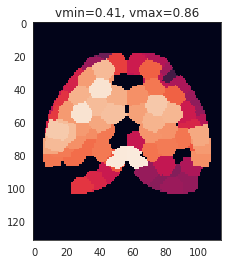

In [27]:
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=np.min(h[h>0]), vmax=np.max(h))
plt.title(f"vmin={np.min(h[h>0]):.2f}, vmax={np.max(h):.2f}")

<AxesSubplot:ylabel='Density'>

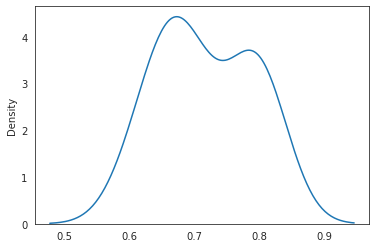

In [28]:
sns.kdeplot(res[2])

In [43]:
eh_boot = entropy_expect_beta(gam_boot)
eh_boot.shape

(10000, 138)

<AxesSubplot:ylabel='Density'>

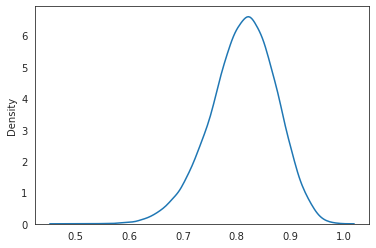

In [44]:
sns.kdeplot(eh_boot[:, 1])

In [30]:
a = np.nanmean(np.nanmean(np.nanmean(group['gam_all'], 2), 1), 0)
eh_avg = entropy_expect_beta(a) # np.nanmean(eh, 0)
h_sort_id = np.argsort(eh_avg)

In [32]:
np.max(eh_avg)

0.9434070286177424

In [33]:
eh_avg[h_sort_id[-1]]

0.9434070286177424

In [34]:
ii = h_sort_id[-1]
sns.kdeplot(eh_boot[:, ii])
plt.axvline(eh_avg[ii], ls='--')

jj = h_sort_id[0]
sns.kdeplot(eh_boot[:, jj], color='r')
plt.axvline(eh_avg[jj], ls='--', color='r')

plt.xlim(0.3, 1);

NameError: name 'eh_boot' is not defined

<AxesSubplot:>

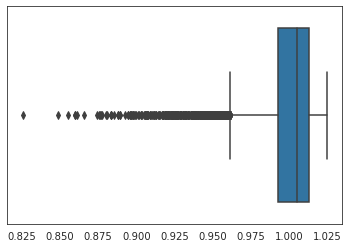

In [50]:
sns.boxplot(eh_boot[:, ii], )

In [51]:
node = h_sort_id[-8]
node

122

In [21]:
pal = sns.cubehelix_palette(n_colors=len(h_sort_id), start=0, rot=1.5, as_cmap=False)

NameError: name 'h_sort_id' is not defined

NameError: name 'eh_boot' is not defined

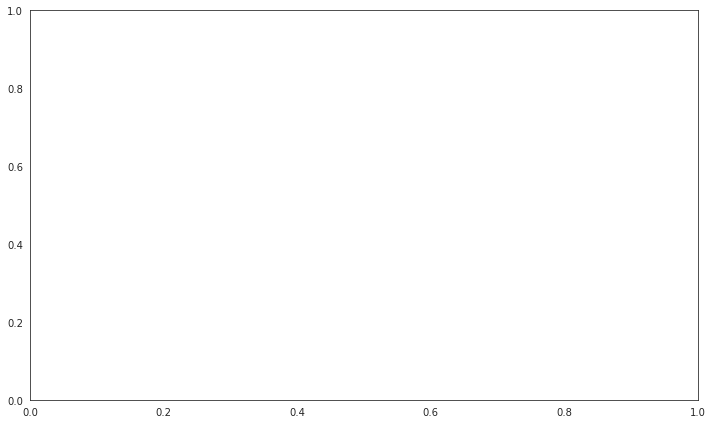

In [36]:
fig, ax = create_figure(1, 1, (10, 6))
sns.kdeplot(
    data={jj: eh_boot[:, i] for jj, i in enumerate(h_sort_id)},
    palette=pal,
    alpha=0.5,
    lw=1,
    legend=False,
    ax=ax,
);

<AxesSubplot:ylabel='Density'>

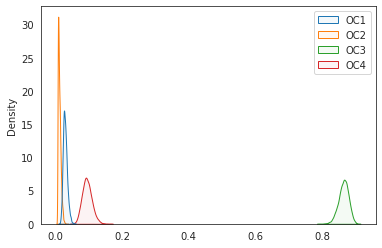

In [54]:
sns.kdeplot(
    data={
        f"OC{i+1}": pi_boot[:, i, h_sort_id[3]]
        for i in range(k)},
    fill=True,
    alpha=0.05,
)

<AxesSubplot:ylabel='Density'>

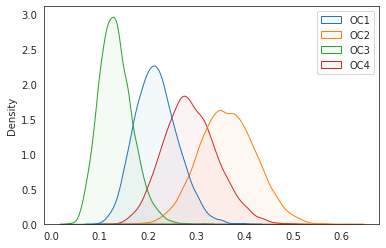

In [56]:
sns.kdeplot(
    data={
        f"OC{i+1}": pi_boot[:, i, h_sort_id[130]]
        for i in range(k)},
    fill=True,
    alpha=0.05,
)

In [37]:
i = 2
a = np.nanmean(np.nanmean(group['pi_all'][..., h_sort_id[0]], 2), 1)
a.shape

(10, 12)

In [38]:
th = 0.8
sp_stats.ttest_1samp(a, th, alternative='less', axis=0)

Ttest_1sampResult(statistic=array([-548.05182136, -761.14862512,  -25.21546966, -418.21420778,
         -1.91206355,  -59.98745958, -344.70634143, -184.29097658,
       -110.11305277,  -18.50444649,  -35.66599442, -294.430038  ]), pvalue=array([5.70680420e-22, 2.96884846e-23, 5.83260575e-10, 6.50369807e-21,
       4.40849552e-02, 2.50529325e-13, 3.70393037e-20, 1.03713061e-17,
       1.06653060e-15, 9.00021988e-09, 2.64865482e-11, 1.53044370e-19]))

## SciPy BCa boot

In [ ]:
my_statistic = get_statistic_fn(
    axis_sub=-1,
    axis_ses=0,
    axis_seed=1,
    est_sub=np.nanmean,
    est_ses=np.nanmean,
    est_seed=np.nanmean,
    keepdims=False,
    dtype=float,
)
n_resamples = 10000
batch = 100
dlist = []
method = 'bca'
ci = 0.95
_boot = sp_stats.bootstrap(
    data=(group['pi_all'],),
    statistic=my_statistic,
    confidence_level=ci,
    n_resamples=n_resamples,
    batch=batch,
    method=method,
    random_state=mice.cfg.random_state,
)

pi_bca = {
    'se': _boot.standard_error,
    'ci_low': _boot.confidence_interval.low,
    'ci_high': _boot.confidence_interval.high,
}
file_name = f"pi_bca{n_resamples:1.0e}"
save_obj(
    obj=pi_bca,
    file_name=file_name,
    save_dir=group_dir,
    mode='npy',
)

In [ ]:
group['pi_all'].shape

In [16]:
pi_bca = np.load(pjoin(group_dir, f"pi_bca{1e4:1.0e}.npy"), allow_pickle=True).item()

In [22]:
p_val = 0.05 # / k
t_val = sp_stats.t.ppf(1 - p_val, df=9)
p_val, t_val

(0.05, 1.8331129326536335)

In [23]:
low = group['pi'] - pi_bca['se'] * t_val
high = group['pi'] + pi_bca['se'] * t_val

<AxesSubplot:label='65c90830-67bf-4089-b39a-4825af2964dc'>

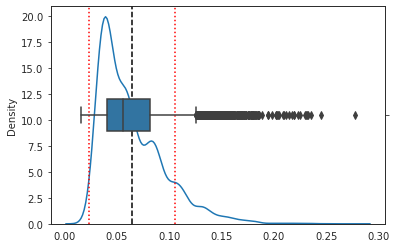

In [32]:
i = 1

ax = sns.kdeplot(pi_boot[:, i, 70])
plt.axvline(group['pi'][i, 70], color='k', ls='--')
plt.axvline(low[i, 70], color='r', ls=':')
plt.axvline(high[i, 70], color='r', ls=':')

ax2 = ax.twinx()
sns.boxplot(pi_boot[:, i, 70], whis=[0, 100 * (1 - p_val)], ax=ax2, width=0.15)

In [34]:
group['pi_all'][..., i, 70].shape

(10, 3, 976)

<AxesSubplot:ylabel='Density'>

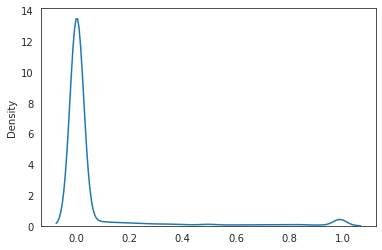

In [53]:
sns.kdeplot(group['pi_all'][..., i, 70].ravel())

In [60]:
np.where(group['pi_all'][..., i, 70] > 0.98)

(
    array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]),
    array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [89]:
th = 0.7
test = high > th

In [90]:
nodes_disjoint = np.where(test.sum(0).astype(bool))[0]
nodes_overlap = np.delete(range(test.shape[1]), nodes_disjoint)

portion_disjoint = len(nodes_disjoint) / test.shape[1]
portion_overlap = 1 - portion_disjoint
portion_disjoint, portion_overlap

(0.2971014492753623, 0.7028985507246377)

<matplotlib.colorbar.Colorbar object at 0x7f2228e12a00>

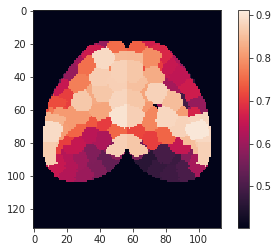

In [91]:
a = np.nanmean(np.nanmean(group['gam_all'], 2), 1)
eh_avg = entropy_expect_beta(a).mean(0)
mask = svinet.pi2arr(eh_avg.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(eh_avg), vmax=max(eh_avg))
plt.colorbar()

In [92]:
dlist = []
dlist.append({
    'node': nodes_overlap,
    'h': eh_avg[nodes_overlap],
    'node_type': ['overlap'] * len(nodes_overlap),
    'graph_type': ['real'] * len(nodes_overlap),
})
dlist.append({
    'node': nodes_disjoint,
    'h': eh_avg[nodes_disjoint],
    'node_type': ['disjoint'] * len(nodes_disjoint),
    'graph_type': ['real'] * len(nodes_disjoint),
})
df_h = pd.DataFrame(merge_dicts(dlist))

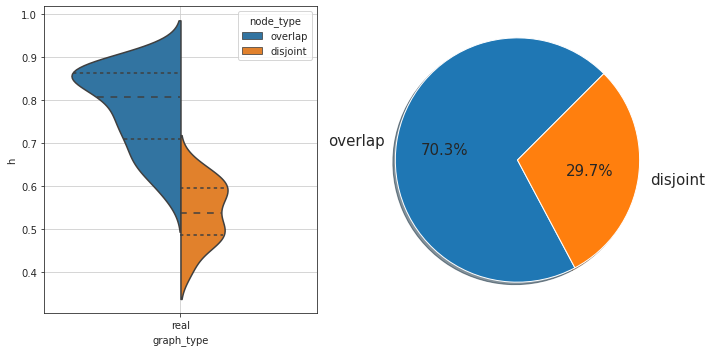

In [93]:
fig, axes = create_figure(1, 2, (10, 5), 'ticks')
sns.violinplot(
    data=df_h,
    hue='node_type',
    x='graph_type',
    y='h',
    scale='count',
    inner='quartile',
    split=True,
    ax=axes[0],
)
axes[0].grid()
axes[1].pie(
    x=[portion_overlap, portion_disjoint],
    labels=['overlap', 'disjoint'],
    explode=(0, 0),
    autopct='%1.1f%%',
    shadow=True,
    startangle=45,
    textprops={'fontsize': 15},
)
axes[1].axis('equal')
plt.show()

In [94]:
_df = df_h.loc[df_h.node_type == 'disjoint']
_df

node 
 h 
 node_type 
 graph_type 
 
 
 
 
 97 
 5 
 0.602600 
 disjoint 
 real 
 
 
 98 
 8 
 0.617703 
 disjoint 
 real 
 
 
 99 
 11 
 0.581952 
 disjoint 
 real 
 
 
 100 
 14 
 0.524038 
 disjoint 
 real 
 
 
 101 
 15 
 0.595373 
 disjoint 
 real 
 
 
 102 
 17 
 0.467267 
 disjoint 
 real 
 
 
 103 
 18 
 0.522288 
 disjoint 
 real 
 
 
 104 
 23 
 0.525111 
 disjoint 
 real 
 
 
 105 
 26 
 0.490382 
 disjoint 
 real 
 
 
 106 
 28 
 0.625789 
 disjoint 
 real 
 
 
 107 
 32 
 0.549744 
 disjoint 
 real 
 
 
 108 
 35 
 0.536172 
 disjoint 
 real 
 
 
 109 
 54 
 0.578924 
 disjoint 
 real 
 
 
 110 
 58 
 0.532908 
 disjoint 
 real 
 
 
 111 
 74 
 0.619995 
 disjoint 
 real 
 
 
 112 
 77 
 0.652005 
 disjoint 
 real 
 
 
 113 
 78 
 0.581288 
 disjoint 
 real 
 
 
 114 
 80 
 0.586534 
 disjoint 
 real 
 
 
 115 
 83 
 0.484988 
 disjoint 
 real 
 
 
 116 
 84 
 0.642836 
 disjoint 
 real 
 
 
 117 
 86 
 0.480576 
 disjoint 
 real 
 
 
 118 
 87 
 0.467921 
 disjoint 
 real 
 
 
 119 
 89 
 0.610374 
 disjoint 
 real 
 
 
 120 
 92 
 0.403561 
 disjoint 
 real 
 
 
 121 
 95 
 0.406664 
 disjoint 
 real 
 
 
 122 
 96 
 0.493074 
 disjoint 
 real 
 
 
 123 
 97 
 0.602361 
 disjoint 
 real 
 
 
 124 
 101 
 0.405357 
 disjoint 
 real 
 
 
 125 
 102 
 0.593214 
 disjoint 
 real 
 
 
 126 
 104 
 0.447492 
 disjoint 
 real 
 
 
 127 
 110 
 0.572943 
 disjoint 
 real 
 
 
 128 
 120 
 0.648729 
 disjoint 
 real 
 
 
 129 
 123 
 0.556473 
 disjoint 
 real 
 
 
 130 
 124 
 0.497542 
 disjoint 
 real 
 
 
 131 
 126 
 0.574972 
 disjoint 
 real 
 
 
 132 
 127 
 0.459671 
 disjoint 
 real 
 
 
 133 
 128 
 0.483431 
 disjoint 
 real 
 
 
 134 
 129 
 0.614230 
 disjoint 
 real 
 
 
 135 
 130 
 0.476875 
 disjoint 
 real 
 
 
 136 
 131 
 0.501235 
 disjoint 
 real 
 
 
 137 
 132 
 0.488181 
 disjoint 
 real

In [95]:
_df.iloc[_df.h.argmax()].values

array([77, 0.6520054369267355, 'disjoint', 'real'], dtype=object)

(0.0, 1.0)

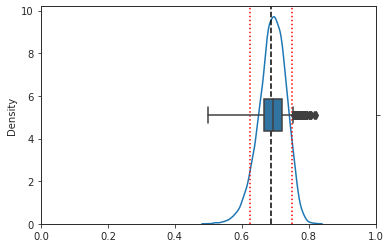

In [96]:
i = 2
j = 89

ax = sns.kdeplot(pi_boot[:, i, j])
plt.axvline(group['pi'][i, j], color='k', ls='--')
plt.axvline(low[i, j], color='r', ls=':')
plt.axvline(high[i, j], color='r', ls=':')

ax2 = ax.twinx()
sns.boxplot(pi_boot[:, i, j], whis=[0, 100 * (1 - p_val)], ax=ax2, width=0.15)
ax.set_xlim(0,1)

In [97]:
deg = svinet.centralities[20].loc[svinet.centralities[20].measure == 'degree'].centrality.values

<AxesSubplot:>

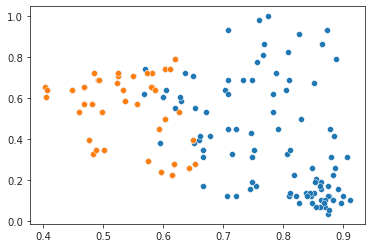

In [98]:
sns.scatterplot(eh_avg, deg)
sns.scatterplot(eh_avg[nodes_disjoint], deg[nodes_disjoint])

In [81]:
comm = svinet.disjoint_community(group['pi'])
masks = svinet.masks_from_pi(group['pi'], disjoint=True, cortex_only=True)

<matplotlib.image.AxesImage object at 0x7f2264ef8dc0>

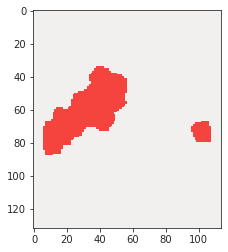

In [82]:
idx = 4
x_arr = project_vol_2d(masks[idx], dims_flat=mice.allen['dims_flat'], mode='max_proj')
plt.imshow(x_arr, cmap=svinet.cmaps[idx])

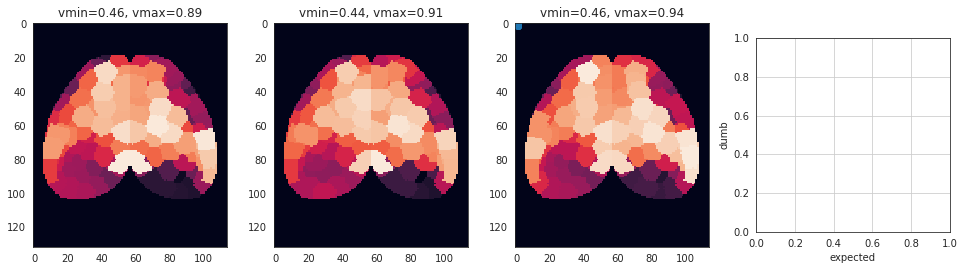

In [268]:
fig, axes = create_figure(1, 4, (13.5, 4.5))

_h1 = np.nanmean(eh, 0)
mask = svinet.pi2arr(_h1.reshape(1, -1), cortex_only=True)[1]
axes[0].imshow(mask, vmin=np.min(_h1), vmax=np.max(_h1))
axes[0].set_title(f"vmin={np.min(_h1):.2f}, vmax={np.max(_h1):.2f}")

_h0 = np.nanmedian(eh, 0)
mask = svinet.pi2arr(_h0.reshape(1, -1), cortex_only=True)[1]
axes[1].imshow(mask, vmin=np.min(_h0), vmax=np.max(_h0))
axes[1].set_title(f"vmin={np.min(_h0):.2f}, vmax={np.max(_h0):.2f}")

_h = ent_dumb
mask = svinet.pi2arr(_h.reshape(1, -1), cortex_only=True)[1]
axes[2].imshow(mask, vmin=np.min(_h), vmax=np.max(_h))
axes[2].set_title(f"vmin={np.min(_h):.2f}, vmax={np.max(_h):.2f}")

sns.regplot(_h1, _h, ax=axes[2])
axes[3].set_xlabel('expected')
axes[3].set_ylabel('dumb')
axes[3].set_aspect('equal')
axes[3].grid()

In [67]:
- 0.1 * np.log(0.1)

0.23025850929940456

In [262]:
sum(counts.values())

{'Q0': 0, 'Q1': 0, 'Q2': 4, 'Q3': 6}

In [ ]:
{
    'ENT-L': (counts['Q0'] + counts['Q1']) / sum(counts.values()),
    'ENT-M': (counts['Q1'] + counts['Q2']) / sum(counts.values()),
    'ENT-H': (counts['Q2'] + counts['Q3']) / sum(counts.values()),
}

In [157]:
_h = entropy_expect_beta(group['gam'])
_h.shape

(138,)

<matplotlib.image.AxesImage object at 0x7f392c8da160>

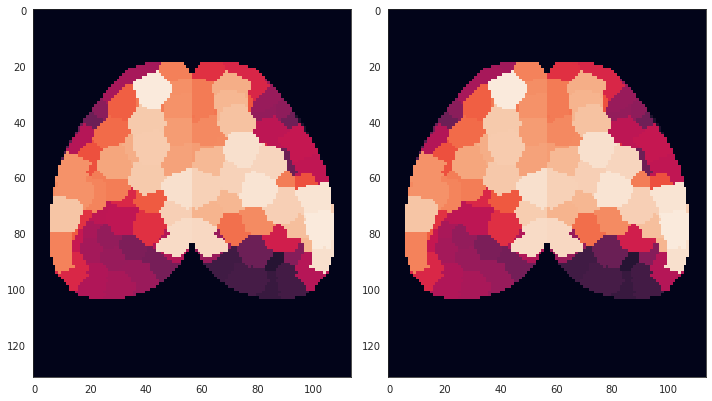

In [158]:
fig, axes = create_figure(1, 2, (10, 7))

mask = svinet.pi2arr(_h.reshape(1, -1), cortex_only=True)[1]
axes[0].imshow(mask, vmin=min(_h), vmax=max(_h))

mask = svinet.pi2arr(ent_dumb.reshape(1, -1), cortex_only=True)[1]
axes[1].imshow(mask, vmin=min(ent_dumb), vmax=max(ent_dumb))

In [159]:
min(_h), max(_h)

(0.4796855872501549, 0.9585487957059863)

In [411]:
np.where(np.isnan(ent_expect))

(
    array([0, 0, 0, ..., 9, 9, 9]),
    array([0, 0, 0, ..., 1, 1, 1]),
    array([  0,   1,   2, ..., 836, 836, 836]),
    array([129, 129, 129, ...,  44, 113, 124])
)

In [15]:
figs, sups = plot_bootstrap(figs_dir, booted, svinet.colors, [str(e) for e in intervals], 'hist')
figs, sups = plot_bootstrap(figs_dir, booted, svinet.colors, [str(e) for e in intervals], 'kde')

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/hist_bins-10_boot-1e+04.pdf

done.

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/kde_bins-10_boot-1e+04.pdf

done.

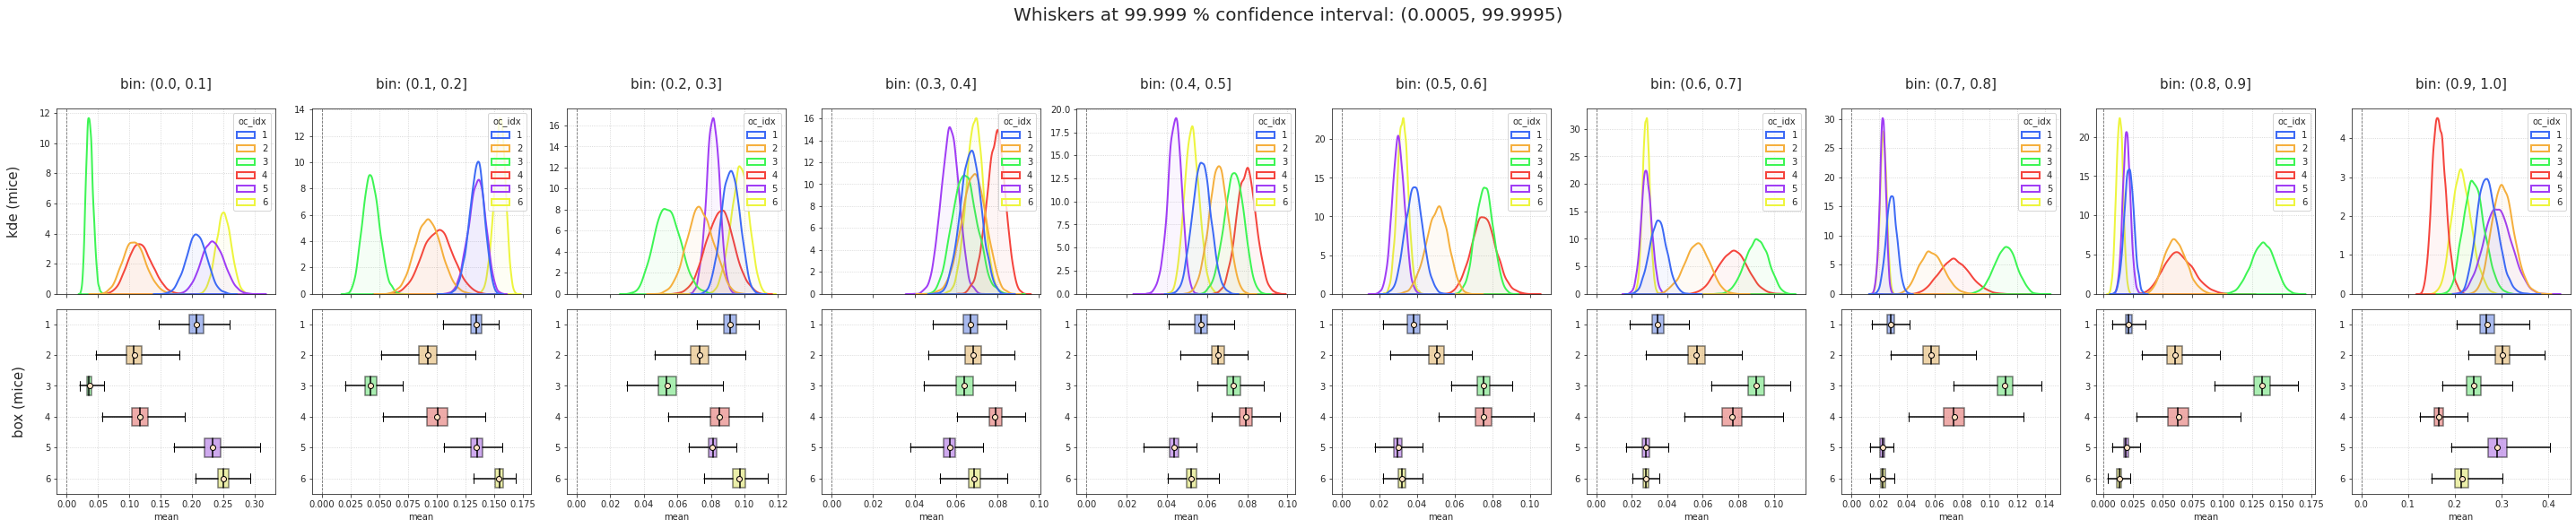

In [16]:
figs[-1]

In [21]:
[e for e in os.listdir(figs_dir) if 'npy' in e]

['cut-oc_bins-10.npy', 'booted-oc_bins-10_boot-1e+04.npy']

## SciPy Boot

In [22]:
my_statistic = get_statistic_fn(
    axis_sub=-1,
    axis_ses=0,
    axis_seed=1,
    keepdims=False,
    dtype=float,
)
n_resamples = 10000
batch = 2000
dlist = []
method = 'bca'
ci = 99.9
boot = sp_stats.bootstrap(
    data=(data_all,),
    statistic=my_statistic,
    confidence_level=ci/100,
    n_resamples=n_resamples,
    batch=batch,
    method=method,
    random_state=mice.cfg.random_state,
)

In [23]:
boot.standard_error

array([[0.01424201, 0.00535805, 0.00485735, 0.00397629, 0.00371928,
        0.00398988, 0.00439758, 0.00323872, 0.00352239, 0.01758454],
       [0.0140842 , 0.00833121, 0.00643357, 0.0053721 , 0.00357011,
        0.00438428, 0.00472382, 0.00674219, 0.00695908, 0.01871863],
       [0.00456345, 0.00624264, 0.0064267 , 0.00481555, 0.00445535,
        0.00376705, 0.00486817, 0.00616496, 0.00734718, 0.0202638 ],
       [0.0125659 , 0.00912745, 0.00617892, 0.00351437, 0.00341073,
        0.00406372, 0.00505067, 0.00854501, 0.00985853, 0.01118936],
       [0.01645829, 0.00670721, 0.00240115, 0.00281473, 0.00250767,
        0.00234332, 0.00206258, 0.00150486, 0.00231202, 0.02660409],
       [0.01027638, 0.00328249, 0.0036399 , 0.00219623, 0.00239537,
        0.00183878, 0.00151675, 0.00204267, 0.0022742 , 0.01402824]])

In [24]:
100 * (1 - 0.05 / 6)

99.16666666666667

In [27]:
boot.confidence_interval

ConfidenceInterval(low=array([[0.16299788, 0.11439128, 0.07537326, 0.05456608, 0.04340583,
        0.02504375, 0.02176093, 0.01916549, 0.01078964, 0.2278044 ],
       [0.06491725, 0.06595956, 0.05403557, 0.04996249, 0.05499547,
        0.03282023, 0.04093808, 0.04026682, 0.04028609, 0.25489541],
       [0.0247164 , 0.02605457, 0.03580494, 0.04957356, 0.05540866,
        0.06397393, 0.07346311, 0.09000358, 0.10071379, 0.18968931],
       [0.08005183, 0.0722386 , 0.06812345, 0.06505508, 0.06937702,
        0.06241593, 0.06049158, 0.05238466, 0.03724037, 0.14488182],
       [0.17997978, 0.11064514, 0.07418794, 0.04728167, 0.03266405,
        0.02248267, 0.02085926, 0.01799767, 0.0105893 , 0.20600311],
       [0.21356707, 0.14234903, 0.08646321, 0.06221028, 0.04551402,
        0.02717492, 0.02391779, 0.01620615, 0.00533432, 0.1767775 ]]), high=array([[0.25374534, 0.14926265, 0.10515378, 0.07872001, 0.06680032,
        0.04986906, 0.04949074, 0.03936925, 0.032732  , 0.33762556],
       [0.1501238 , 0.11857895, 0.09489875, 0.08547422, 0.077294  ,
        0.06057464, 0.06980939, 0.0824857 , 0.08383312, 0.37692558],
       [0.05402637, 0.06673029, 0.07587693, 0.07968841, 0.08357547,
        0.08850651, 0.10464581, 0.13075589, 0.15078943, 0.31800211],
       [0.1571642 , 0.12974104, 0.10914885, 0.08733478, 0.0901859 ,
        0.08799022, 0.09096075, 0.1046824 , 0.09754219, 0.21083274],
       [0.28610653, 0.15097906, 0.09028617, 0.06519387, 0.04795752,
        0.03673529, 0.03402107, 0.02758909, 0.02511773, 0.3743306 ],
       [0.27717635, 0.16383072, 0.10909534, 0.0754608 , 0.06126973,
        0.03929939, 0.03313063, 0.0293177 , 0.01948093, 0.26717647]]))

array([[0.01424201, 0.00535805, 0.00485735, 0.00397629, 0.00371928,
        0.00398988, 0.00439758, 0.00323872, 0.00352239, 0.01758454],
       [0.0140842 , 0.00833121, 0.00643357, 0.0053721 , 0.00357011,
        0.00438428, 0.00472382, 0.00674219, 0.00695908, 0.01871863],
       [0.00456345, 0.00624264, 0.0064267 , 0.00481555, 0.00445535,
        0.00376705, 0.00486817, 0.00616496, 0.00734718, 0.0202638 ],
       [0.0125659 , 0.00912745, 0.00617892, 0.00351437, 0.00341073,
        0.00406372, 0.00505067, 0.00854501, 0.00985853, 0.01118936],
       [0.01645829, 0.00670721, 0.00240115, 0.00281473, 0.00250767,
        0.00234332, 0.00206258, 0.00150486, 0.00231202, 0.02660409],
       [0.01027638, 0.00328249, 0.0036399 , 0.00219623, 0.00239537,
        0.00183878, 0.00151675, 0.00204267, 0.0022742 , 0.01402824]])

In [29]:
file_name = f"scipy-boot-oc_bins-{num_cuts}_boot-{n_resamples:1.0e}"
save_obj(
    obj={
        'se': boot.standard_error,
        'ci_low': boot.confidence_interval.low,
        'ci_high': boot.confidence_interval.high,},
    file_name=file_name,
    save_dir=figs_dir,
    mode='npy',
)

[PROGRESS] 'scipy-boot-oc_bins-10_boot-1e+04.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/figs_combined/real-p20-k6/scipy-boot-oc_bins-10_boot-1e+04.npy'

In [274]:
dlist1, dlist2 = [], []
for i in range(k):
    for j, intvl in enumerate(intervals):
        dlist1.append({
            'condition': ['real'] * len(real_sample),
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'mean': real_sample[:, i, j],
        })
        dlist2.append({
            'condition': ['boot'] * len(booted),
            'interval': [intvl] * len(booted),
            'oc_idx': [i + 1] * len(booted),
            'mean': booted[:, i, j],
        })
df_real = pd.DataFrame(merge_dicts(dlist1))
df_boot = pd.DataFrame(merge_dicts(dlist2))

t = abs(sp_stats.t.ppf(0.75, mice.cfg.num_subjects - 1))
q1 = real[0] - boot.standard_error * t
q3 = real[0] - boot.standard_error * t

dlist = []
ci_all = [95, 99.99, 99.999, 100 * (1 - 0.05 / 6)]
for ci in sorted(ci_all):
    p = np.round(1 - ci / 100, 13)
    t = abs(sp_stats.t.ppf(1 - p, mice.cfg.num_subjects - 1))
    low = real[0] - boot.standard_error * t
    high = real[0] + boot.standard_error * t
    for i in range(k):
        for j, intvl in enumerate(intervals):
            _res = {
                'low': low[i, j],
                'Q1': q1[i, j],
                'Q3': q3[i, j],
                'high': high[i, j],
            }
            dlist.append({
                'p': [p] * len(_res),
                't': [t] * len(_res),
                'ci': [ci] * len(_res),
                'oc_idx': [i + 1] * len(_res),
                'interval': [intvl] * len(_res),
                'label': _res.keys(),
                'value': _res.values(),
            })
df_t = pd.DataFrame(merge_dicts(dlist))

In [275]:
df_t.loc[df_t.interval == intervals[-1]]

p 
 t 
 ci 
 oc_idx 
 interval 
 label 
 value 
 
 
 
 
 36 
 0.05000 
 1.833113 
 95.000 
 1 
 (0.9, 1.0] 
 low 
 0.237742 
 
 
 37 
 0.05000 
 1.833113 
 95.000 
 1 
 (0.9, 1.0] 
 Q1 
 0.257619 
 
 
 38 
 0.05000 
 1.833113 
 95.000 
 1 
 (0.9, 1.0] 
 Q3 
 0.257619 
 
 
 39 
 0.05000 
 1.833113 
 95.000 
 1 
 (0.9, 1.0] 
 high 
 0.302211 
 
 
 76 
 0.05000 
 1.833113 
 95.000 
 2 
 (0.9, 1.0] 
 low 
 0.268470 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 919 
 0.00001 
 8.102058 
 99.999 
 5 
 (0.9, 1.0] 
 high 
 0.507092 
 
 
 956 
 0.00001 
 8.102058 
 99.999 
 6 
 (0.9, 1.0] 
 low 
 0.101344 
 
 
 957 
 0.00001 
 8.102058 
 99.999 
 6 
 (0.9, 1.0] 
 Q1 
 0.205144 
 
 
 958 
 0.00001 
 8.102058 
 99.999 
 6 
 (0.9, 1.0] 
 Q3 
 0.205144 
 
 
 959 
 0.00001 
 8.102058 
 99.999 
 6 
 (0.9, 1.0] 
 high 
 0.328659 
 
 
 
 96 rows × 7 columns

In [327]:
from matplotlib.path import Path

def modify_box(ax, q, axis='x'):
    children = ax.get_children()
    # fix box
    pathpatch = children[6]
    path = pathpatch.get_path()
    vertices = path.vertices.copy()
    vertices[0, 0 if axis == 'x' else 1] = q[1]
    vertices[1, 0 if axis == 'x' else 1] = q[1]
    vertices[2, 0 if axis == 'x' else 1] = q[2]
    vertices[3, 0 if axis == 'x' else 1] = q[2]
    vertices[4, 0 if axis == 'x' else 1] = q[2]
    pathpatch.set_path(Path(vertices, path.codes))
    # fix arms
    children[0].set(**{'xdata' if axis == 'x' else 'ydata': (q[1], q[0])})
    children[1].set(**{'xdata' if axis == 'x' else 'ydata': (q[2], q[3])})
    children[2].set(**{'xdata' if axis == 'x' else 'ydata': (q[0], q[0])})
    children[3].set(**{'xdata' if axis == 'x' else 'ydata': (q[3], q[3])})
    return ax

In [328]:
x = rng.random(10000)
q = [2.5, 25, 50, 75, 97.5]
q = [-0.9, -0.25, 0.25, 0.75]

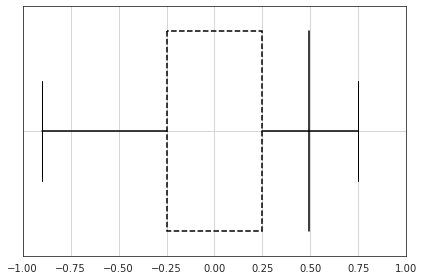

In [329]:
props = {
    'boxprops': {'color': 'none', 'edgecolor': 'k', 'ls': '--'},
    'medianprops': {'color': 'k'},
    'whiskerprops': {'color': 'k'},
    'capprops': {'color': 'k', 'linewidth': 1},
    'flierprops': {'alpha': 0.5, 'zorder': 1},
}

fig, ax = create_figure()
sns.boxplot(x, ax=ax, **props)
ax.set_xlim(-1, 1)
_ = modify_box(ax, q)
ax.grid()
plt.show()

In [371]:
def plot_last_bin(
        save_dir: str,
        booted: np.ndarray,
        df_real: pd.DataFrame,
        standard_error: np.ndarray,
        colors: Dict[int, str],
        dist_names: List[str] = None,
        method: str = 'bca',
        figsize=(13, 9.5),
        ci: float = 99.9, ):
    from fitter import Fitter
    props = {
        'boxprops': {'color': 'none', 'edgecolor': 'k', 'linewidth': 1, 'ls': '--'},
        'medianprops': {'color': 'k', 'linewidth': 1.3},
        'whiskerprops': {'color': 'k', 'linewidth': 1},
        'capprops': {'color': 'k', 'linewidth': 1},
    }
    meanprops = {
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "k",
        "markersize": "10",
    }
    dist_names = dist_names if dist_names else ['beta', 't']
    ci_low = np.round((100 - ci) / 2, 10)
    ci_high = np.round(100 - ci_low, 10)

    intervals = df_real.interval.unique()
    k = len(df_real.oc_idx.unique())
    nrows = 2
    ncols = int(np.ceil(k / nrows))
    fig, axes = create_figure(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        style='ticks',
    )
    axes_twin = np.empty_like(axes)
    for i, ax in enumerate(axes.ravel()):
        f = Fitter(
            data=booted[:, i, -1],
            distributions=dist_names,
            bins=500,
            timeout=1000,
        )
        f.fit(progress=False)
        for _d in dist_names:
            pdf = make_pdf(
                dist=_d,
                params=f.fitted_param[_d],
                whis=(ci_low / 100, ci_high / 100),
                size=10000,
            )
            ax.plot(
                list(pdf.index),
                list(pdf.values),
                color='r' if _d == 't' else 'k',
                lw=1.5,
                label=_d,
            )
        ax.legend(loc='upper right')
        sns.histplot(
            booted[:, i, -1],
            color=colors[i + 1],
            stat='density',
            alpha=0.6,
            ax=ax,
        )
        ax.grid(ls=':')
        ax.set_title(f"OC{i + 1}")
        if i // ncols == nrows - 1:
            ax.set_xlabel('mean portion')
        else:
            ax.set_xlabel('')

        ax_tx = ax.twinx()
        _df = df_real.loc[
            (df_real.oc_idx == i + 1) &
            (df_real.interval == intervals[-1])
            ]
        sns.boxplot(
            data=_df,
            x='mean',
            showmeans=True,
            meanprops=meanprops,
            showfliers=False,
            orient='h',
            width=0.15,
            ax=ax_tx,
            **props,
        )
        ax_tx.set_ylim((0.15, -1.0))
        
        # modify box
        real = _df['mean'].mean()
        # quartiles
        t = abs(sp_stats.t.ppf(0.75, len(_df) - 1))
        q1 = real - boot.standard_error[i, -1] * t
        q3 = real + boot.standard_error[i, -1] * t
        # whiskers
        t = abs(sp_stats.t.ppf(ci / 100, len(_df) - 1))
        low = real - boot.standard_error[i, -1] * t
        high = real + boot.standard_error[i, -1] * t
        ax_tx = modify_box(ax_tx, [low, q1, q3, high], 'x')
        axes_twin.ravel()[i] = ax_tx
        
        # change xlim
        xlim = ax.get_xlim()
        if xlim[0] > low - 0.01:
            xlim = (low - 0.01, xlim[1])
        if xlim[1] < high + 0.01:
            xlim = (xlim[0], high + 0.01)
        ax.set_xlim(xlim)

    plt.draw()
    for ax in axes.ravel():
        ax.set_xticklabels([
            np.round(float(e.get_text()), 2)
            for e in ax.get_xticklabels()
        ])

    msg = f"ci = {ci} %  whiskers: [{ci_low}, {ci_high}]   -   method: {method}\n"
    msg += "median and mean (white circle): 'actual' sample\n"
    msg += "whiskers, caps, hist: 'bootstrapped' samples"
    sup = fig.suptitle(msg, fontsize=17, y=1.05)

    save_file = [
        f"last-bin-{method}",
        f"bins-{len(intervals)}",
        f"boot-{len(booted):1.0e}",
    ]
    save_file = f"{'_'.join(save_file)}.pdf"
    save_file = pjoin(save_dir, save_file)
    print(save_file)
    save_fig(
        fig=fig,
        sup=sup,
        save_file=save_file,
        display=False,
        multi=False,
    )
    print('done.')
    return fig, axes, axes_twin

In [372]:
fig, axes, axes_twin = plot_last_bin(figs_dir, booted, df_real, boot.standard_error, svinet.colors, ci=99.9)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/last-bin-bca_bins-10_boot-1e+04.pdf

done.

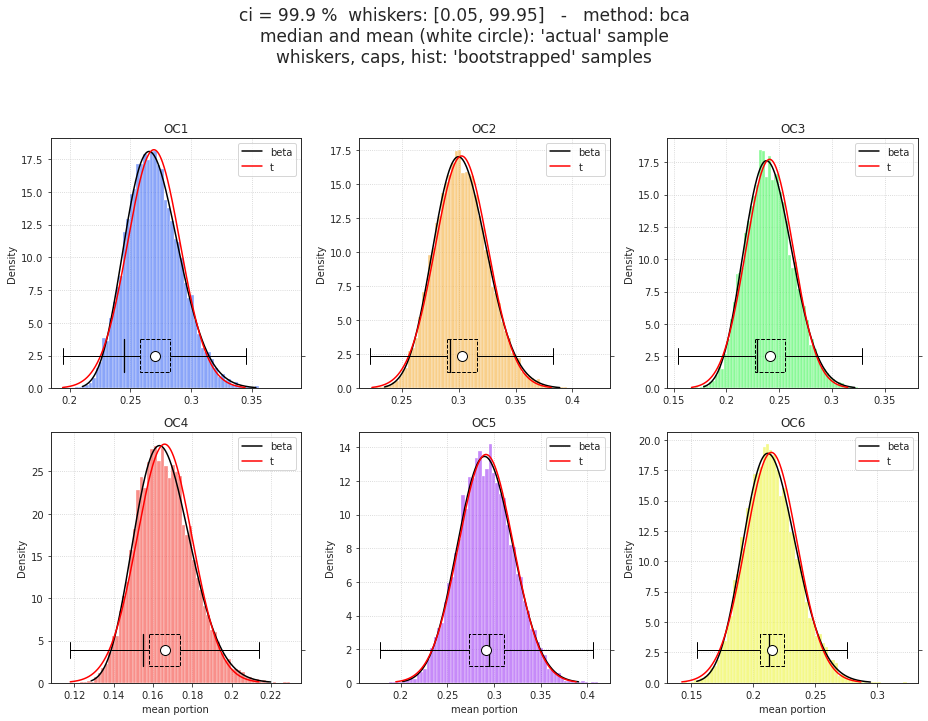

In [373]:
fig

In [368]:
def plot_last_bin(
        save_dir: str,
        booted: np.ndarray,
        df_real: pd.DataFrame,
        df_boot: pd.DataFrame,
        colors: Dict[int, str],
        method='percentile',
        dist_names: List[str] = None,
        figsize=(13, 9.5),
        ci: float = 99.9, ):
    from fitter import Fitter
    props_boot = {
        'boxprops': {'color': 'none', 'edgecolor': 'k', 'linewidth': 1},
        'medianprops': {'color': 'none', 'linewidth': 0},
        'whiskerprops': {'color': 'k', 'linewidth': 1},
        'capprops': {'color': 'k', 'linewidth': 1},
        'flierprops': {'alpha': 0.5, 'zorder': 1},
    }
    props_real = {
        'boxprops': {'color': 'none', 'edgecolor': 'none', 'linewidth': 0},
        'medianprops': {'color': 'k', 'linewidth': 1.5},
        'whiskerprops': {'color': 'none', 'linewidth': 0},
        'capprops': {'color': 'none', 'linewidth': 0},
        'flierprops': {'alpha': 0.7, 'zorder': 1},
    }
    meanprops = {
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "k",
        "markersize": "10",
    }
    dist_names = dist_names if dist_names else ['beta', 't']
    ci_low = np.round((100 - ci) / 2, 10)
    ci_high = np.round(100 - ci_low, 10)

    intervals = df_real.interval.unique()
    k = len(df_real.oc_idx.unique())
    nrows = 2
    ncols = int(np.ceil(k / nrows))
    fig, axes = create_figure(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        style='ticks',
    )
    for i, ax in enumerate(axes.ravel()):
        f = Fitter(
            data=booted[:, i, -1],
            distributions=dist_names,
            bins=500,
            timeout=1000,
        )
        f.fit(progress=False)
        for _d in dist_names:
            pdf = make_pdf(
                dist=_d,
                params=f.fitted_param[_d],
                whis=(ci_low / 100, ci_high / 100),
                size=10000,
            )
            ax.plot(
                list(pdf.index),
                list(pdf.values),
                color='r' if _d == 't' else 'k',
                lw=1.5,
                label=_d,
            )
        ax.legend(loc='upper right')
        sns.histplot(
            booted[:, i, -1],
            color=colors[i + 1],
            stat='density',
            alpha=0.6,
            ax=ax,
        )
        ax.grid(ls=':')
        ax.set_title(f"OC{i + 1}")

        ax_tx = ax.twinx()
        _df = df_boot.loc[
            (df_boot.oc_idx == i + 1) &
            (df_boot.interval == intervals[-1])
            ]
        sns.boxplot(
            data=_df,
            x='mean',
            whis=(ci_low, ci_high),
            showfliers=True,
            orient='h',
            width=0.15,
            ax=ax_tx,
            **props_boot,
        )

        _df = df_real.loc[
            (df_real.oc_idx == i + 1) &
            (df_real.interval == intervals[-1])
            ]
        sns.boxplot(
            data=_df,
            x='mean',
            showmeans=True,
            meanprops=meanprops,
            showfliers=True,
            orient='h',
            width=0.15,
            ax=ax_tx,
            **props_real,
        )
        ax_tx.set_ylim((0.15, -1.0))
        if i // ncols == nrows - 1:
            ax.set_xlabel('mean portion')
        else:
            ax.set_xlabel('')
    plt.draw()
    for ax in axes.ravel():
        ax.set_xticklabels([
            np.round(float(e.get_text()), 2)
            for e in ax.get_xticklabels()
        ])

    msg = f"ci = {ci} %  whiskers: [{ci_low}, {ci_high}]   -   method: {method}\n"
    msg += "median and mean (white circle): 'actual' sample\n"
    msg += "whiskers, caps, hist: 'bootstrapped' samples"
    sup = fig.suptitle(msg, fontsize=17, y=1.05)

    save_file = [
        f"last-bin-{method}",
        f"bins-{len(intervals)}",
        f"boot-{len(booted):1.0e}",
    ]
    save_file = f"{'_'.join(save_file)}.pdf"
    save_file = pjoin(save_dir, save_file)
    print(save_file)
    save_fig(
        fig=fig,
        sup=sup,
        save_file=save_file,
        display=False,
        multi=False,
    )
    print('done.')
    return fig, axes

In [369]:
fig, axes = plot_last_bin(figs_dir, booted, df_real, df_boot, svinet.colors, ci=99.9)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/last-bin-percentile_bins-10_boot-1e+04.pdf

done.

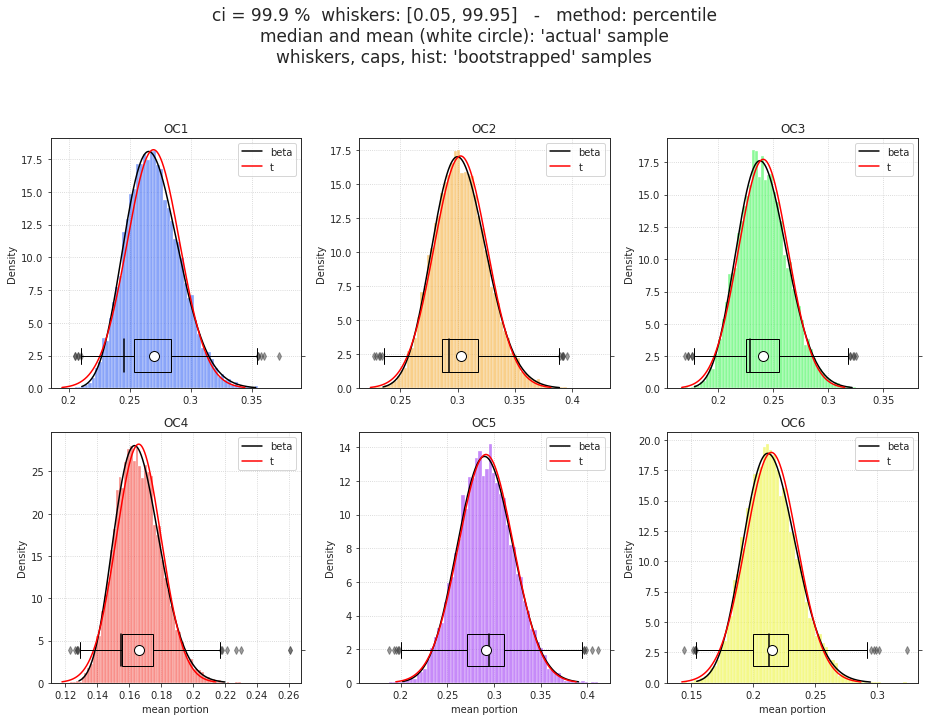

In [370]:
fig

## New, correct Fig

In [17]:
real_sample = np.median(data_all, axis=2).mean(1, dtype='float128')
real_sample.shape, booted.shape, real.shape, data_all.shape

((10, 6, 10), (10000, 6, 10), (1, 6, 10), (10, 3, 943, 6, 10))

In [18]:
dlist1, dlist2 = [], []
for i in range(k):
    for j, intvl in enumerate(intervals):
        dlist1.append({
            'condition': ['real'] * len(real_sample),
            'interval': [intvl] * len(real_sample),
            'oc_idx': [i + 1] * len(real_sample),
            'mean': real_sample[:, i, j],
        })
        dlist2.append({
            'condition': ['boot'] * len(booted),
            'interval': [intvl] * len(booted),
            'oc_idx': [i + 1] * len(booted),
            'mean': booted[:, i, j],
        })
df_real = pd.DataFrame(merge_dicts(dlist1))
df_boot = pd.DataFrame(merge_dicts(dlist2))
df_real.shape, df_boot.shape

((600, 4), (600000, 4))

In [21]:
figs, sups = plot_group(figs_dir, df_real, df_boot, figsize=(13.5, 11.3))

  0%|          | 0/4 [00:00<?, ?it/s]

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/group_bins-10_boot-1e+04.pdf

done.

In [26]:
fig, axes = plot_last_bin(figs_dir, booted, df_real, df_boot, svinet.colors)

/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6/last-bin_bins-10_boot-1e+04.pdf

done.

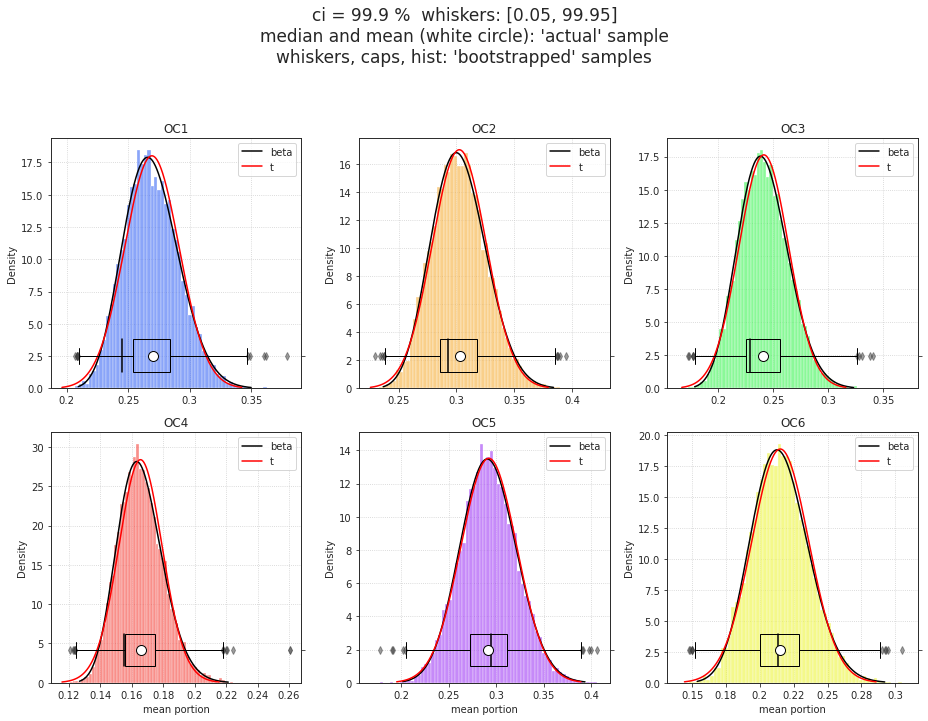

In [27]:
fig

## Integrate out communities

  0%|          | 0/30 [00:00<?, ?it/s]

((10, 3, 943, 138), (10, 3, 943, 6, 138))

In [128]:
np.nanmin(h_all), np.nanmax(h_all)

(0.04702574289752963, 1.0)

In [115]:
x = np.round(np.nansum(pi_all, axis=3).ravel(), 10)
collections.Counter(x).most_common()

[(1.0, 3857813), (0.0, 46207)]

In [110]:
np.isnan(h_all).sum(), np.isnan(pi_all).sum()

(46207, 277242)

In [116]:
np.where(np.nansum(pi_all, axis=3) == 0)

(
    array([0, 0, 0, ..., 9, 9, 9]),
    array([0, 0, 0, ..., 1, 1, 1]),
    array([  0,   1,   2, ..., 942, 942, 942]),
    array([129, 129, 129, ...,  44, 113, 124])
)

In [117]:
pi_all[0, 0, 0, :, 129]

array([nan, nan, nan, nan, nan, nan])

In [127]:
rng = get_rng()
num_cuts = 10
bins = np.linspace(0, 1, num_cuts + 1)
intervals = pd.cut([], bins).value_counts().index

cut_nodes = np.ones((
    mice.cfg.num_subjects,
    mice.cfg.num_sessions,
    min(seed_counts.values()),
    num_nodes, num_cuts,
)) * -1
cut_h = np.zeros((
    mice.cfg.num_subjects,
    mice.cfg.num_sessions,
    min(seed_counts.values()),
    num_cuts,
))

for sub_i in tqdm(range(pi_all.shape[0])):
    for ses_i in range(pi_all.shape[1]):
        if not (sub_i == 1 and ses_i == 1):
            continue
        for seed_i in tqdm(range(pi_all.shape[2]), leave=False):
            _h = h_all[sub_i, ses_i, seed_i]
            _cut = pd.cut(np.round(_h, 2), bins)
            counts = _cut.value_counts().values
            portions = [c / sum(counts) for c in counts]
            cut_h[sub_i, ses_i, seed_i] = portions
            
            good_nodes = np.where(~np.isnan(_h))[0]
            for node_i in good_nodes:
                _cut = pd.cut(np.round(pi_all[sub_i, ses_i, seed_i, :, node_i], 2), bins)
                counts = _cut.value_counts().values
                portions = [c / sum(counts) for c in counts]
                cut_nodes[sub_i, ses_i, seed_i, node_i] = portions
cut_nodes.shape, cut_h.shape

<AxesSubplot:ylabel='Count'>

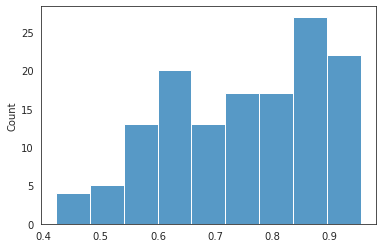

In [190]:
h = sp_stats.entropy(output['pi'], axis=0) / np.log(k)
sns.histplot(h)

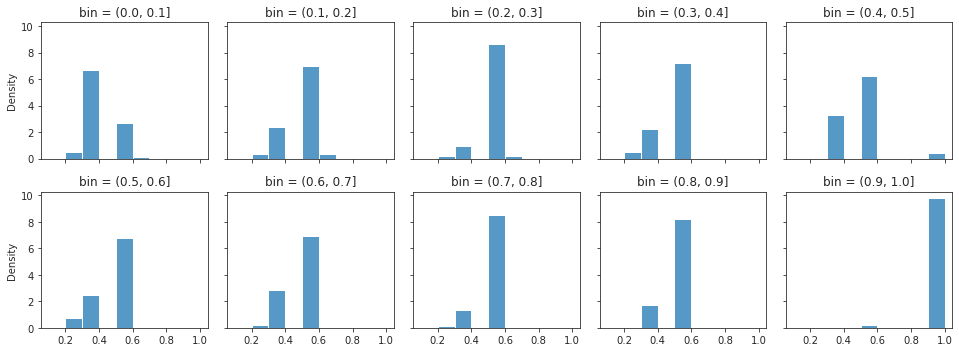

In [199]:
nrows = 2
ncols = int(np.ceil(num_cuts / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 5), 'ticks', 'all', 'all')

node = np.argmax(h)
for i, ax in enumerate(axes.ravel()):
    sns.histplot(cut_nodes[1, 1, :, node, i], bins=np.linspace(0.1, 1, 10), ax=ax, stat='density')
    ax.set_title(f"bin = {intervals[i]}")

<AxesSubplot:ylabel='Count'>

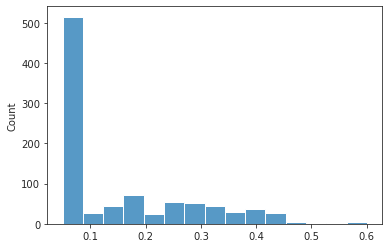

In [198]:
sns.histplot(h_all[1, 1, :, node])

In [126]:
pd.cut([0, 0.04, 0.2, 0.33, 0.23, 0.25, 0.26, 1, 0.54, 0, 0, np.nan, np.nan], np.linspace(0, 1, 11)).value_counts().values

array([1, 1, 3, 1, 0, 1, 0, 0, 0, 1])

In [68]:


for key, sv in tqdm(output['svinet_all'].items()):
    sub, ses, _ = mice.looper[key]
    
    if not (sub == 2 and ses == 2):
        continue
    
    reord_ids = list(output['perms'][key].values())
    g = sv.gam_all[:, reord_ids, :]
    pi = g / g.sum(1, keepdims=True)
    seed_ids = rng.choice(len(pi), min(seed_counts.values()), False)
    pi = pi[seed_ids]
    h = sp_stats.entropy(pi, axis=1) / np.log(k)
    entropies[sub - 1, ses - 1] = h
    
    nans = np.isnan(pi).sum(0).sum(0).astype(bool)
    good_nodes = np.where(~nans)[0]
    for i in range(len(pi)):
        mem_cut = pd.cut(np.round(h[i], 2), bins)
        mem_cut = mem_cut.value_counts()
        counts = mem_cut.values
        portions = [c / sum(counts) for c in counts]
        entropies_cut[sub - 1, ses - 1, i] = portions
        for j in good_nodes:
            mem_cut = pd.cut(np.round(pi[i, :, j], 2), bins)
            mem_cut = mem_cut.value_counts()
            counts = mem_cut.values
            portions = [c / sum(counts) for c in counts]
            pi_cut_nodes[sub - 1, ses - 1, i, j] = portions

pi_cut_nodes.shape

  0%|          | 0/30 [00:00<?, ?it/s]

(10, 3, 943, 138, 20)

In [69]:
nans.sum()

8

In [129]:
np.where(cut_nodes[1, 1] == -1)

(
    array([  0,   0,   0, ..., 942, 942, 942]),
    array([  6,   6,   6, ..., 120, 120, 120]),
    array([0, 1, 2, ..., 7, 8, 9])
)

In [130]:
cut_nodes[1, 1].shape

(943, 138, 10)

In [65]:
np.nanmin(h)

0.049474011436324614

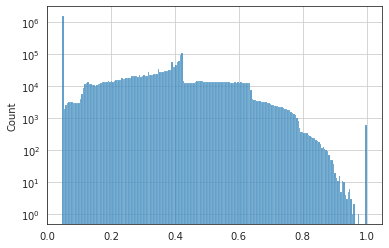

In [163]:
x = h_all[~np.isnan(h_all)].ravel()
sns.histplot(x)
plt.yscale('log')
plt.grid()

In [172]:
h = np.nanmean(np.nanmean(np.nanmedian(h_all, 2), 1), 0)

In [173]:
h.shape

(138,)

[<matplotlib.lines.Line2D object at 0x7f85012a1d30>]

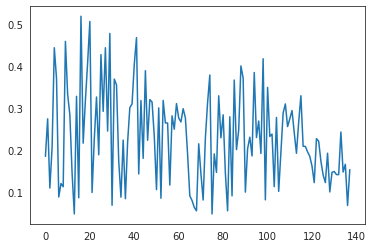

In [174]:
plt.plot(h)

In [177]:
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]

<matplotlib.image.AxesImage object at 0x7f85045604c0>

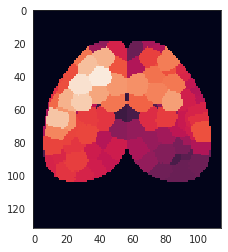

In [179]:
plt.imshow(mask)

<matplotlib.colorbar.Colorbar object at 0x7f8502139640>

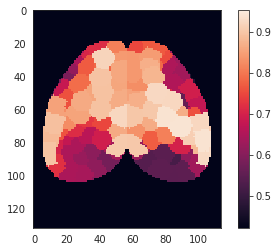

In [189]:
h = sp_stats.entropy(output['pi'], axis=0) / np.log(k)
mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
plt.imshow(mask, vmin=min(h), vmax=max(h))
plt.colorbar()

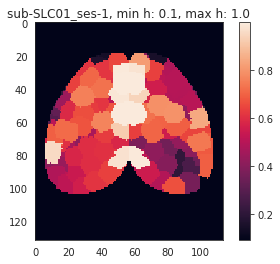

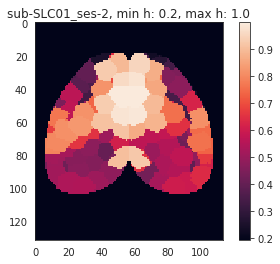

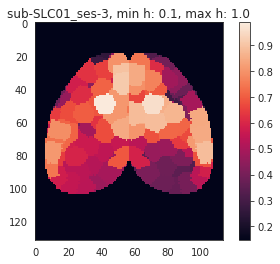

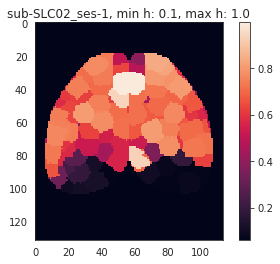

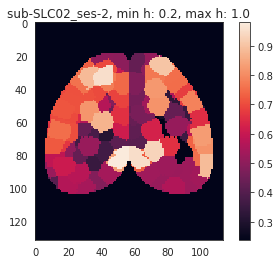

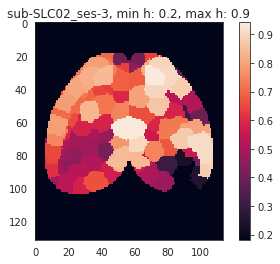

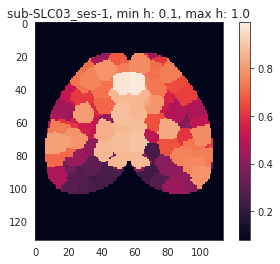

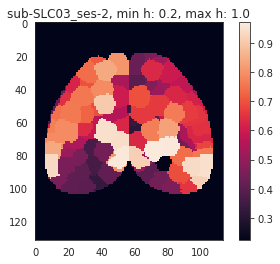

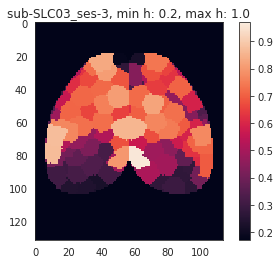

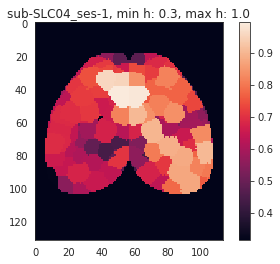

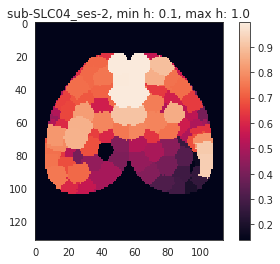

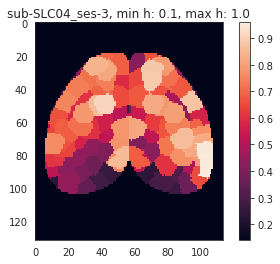

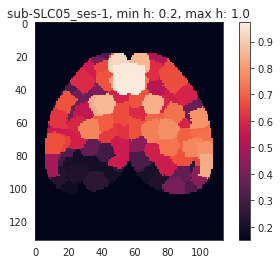

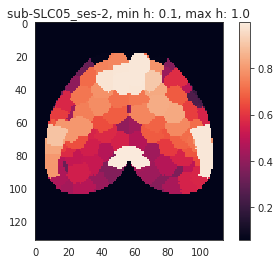

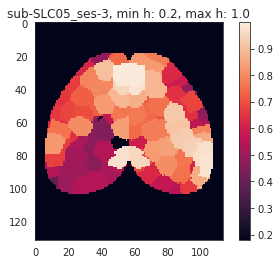

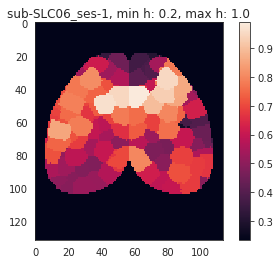

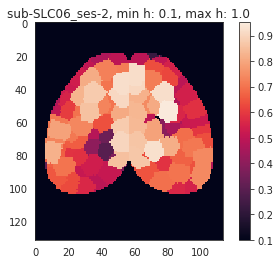

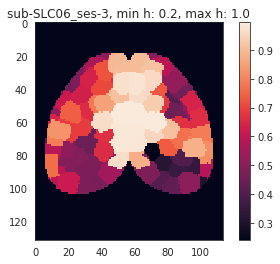

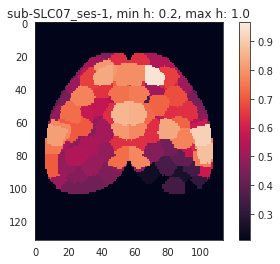

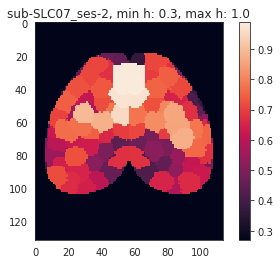

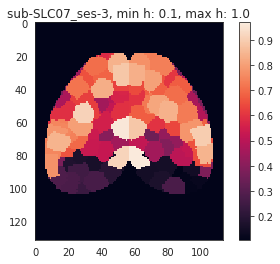

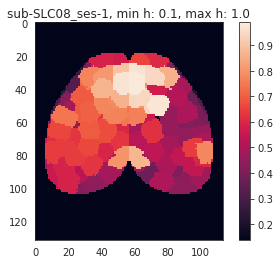

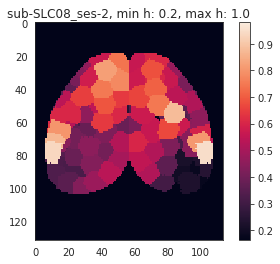

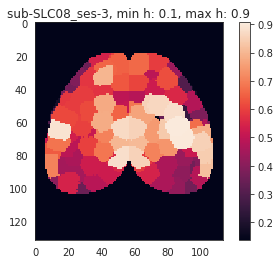

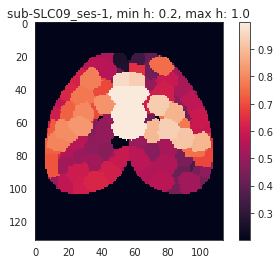

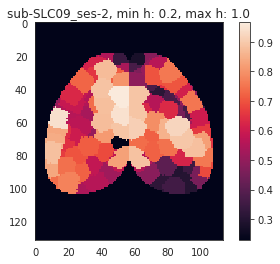

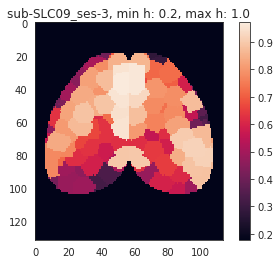

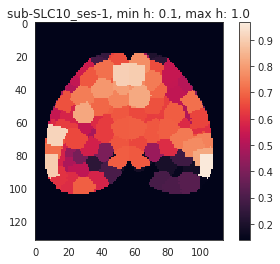

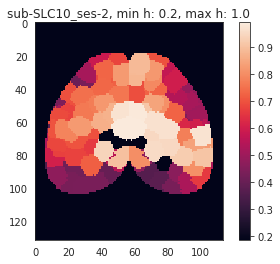

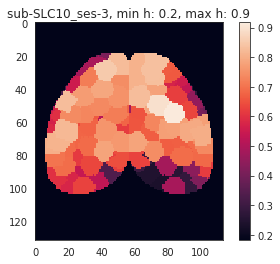

In [232]:
for key, gam in output['gamma_all'].items():
    _pi = gam / gam.sum(0, keepdims=True)
    h = sp_stats.entropy(_pi, axis=0) / np.log(k)
    mask = svinet.pi2arr(h.reshape(1, -1), cortex_only=True)[1]
    plt.imshow(mask, vmin=np.nanmin(h), vmax=np.nanmax(h))
    plt.colorbar()
    plt.title(f"{key}, min h: {np.nanmin(h):.1f}, max h: {np.nanmax(h):.1f}")
    plt.show()

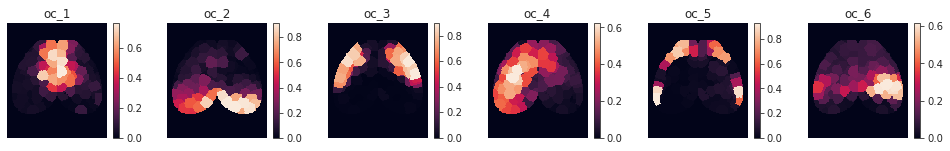

In [233]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (13.5, 2.1))
gam_arr = svinet.pi2arr(_pi, cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
    plt.colorbar(im, ax=ax)
remove_ticks(axes)
plt.show()

In [223]:
h

array([0.41492661, 0.82672472, 0.68213581, 0.49205765, 0.8520797 ,
       0.48596108, 0.62768482, 0.5790587 , 0.35321321, 0.71733458,
       0.74400477, 0.40248991, 0.72536875, 0.53442075, 0.53344934,
       0.55481887, 0.78985376, 0.46669976, 0.32517561, 0.75238062,
       0.76862138, 0.64853976, 0.8304846 , 0.64623488, 0.63306944,
       0.73964554, 0.49402841, 0.74068415, 0.66310339, 0.73283696,
       0.67956947, 0.71775953, 0.59656554, 0.56859275, 0.51933401,
       0.48605415, 0.61826302, 0.64192505, 0.7573    , 0.67792683,
       0.82294287, 0.55990795, 0.58558356, 0.68144527, 0.76534287,
       0.81255845, 0.80537844, 0.68901322, 0.68844073, 0.78444326,
       0.29707637, 0.61358312, 0.64504729, 0.70439327, 0.62323062,
       0.63554016, 0.1975646 , 0.69376857, 0.33557285, 0.5439305 ,
       0.60106718, 0.52730022, 0.5776906 , 0.6279179 , 0.18268549,
       0.18612312, 0.20793517, 0.18336582, 0.19350218, 0.83474386,
       0.80962794, 0.644751  , 0.66527682, 0.83615909, 0.66426029,
       0.6589592 , 0.83339958, 0.57346567, 0.5123289 , 0.81023408,
       0.55602042, 0.67613822, 0.633046  , 0.3811772 , 0.53047392,
       0.78239416, 0.50125741, 0.27102729, 0.83035434, 0.62368447,
       0.52923295, 0.45612928, 0.44468127, 0.78958639, 0.89558963,
       0.38774349, 0.6337868 , 0.66035631, 0.9178147 , 0.47338839,
       0.65392301, 0.40807053, 0.26077487, 0.73143169, 0.77507828,
       0.65866328, 0.77807878, 0.66824165, 0.77633856, 0.7954267 ,
       0.77265986, 0.80269134, 0.67325811, 0.78316087, 0.68911306,
       0.73735492, 0.66862073, 0.66567009, 0.74462057, 0.2642169 ,
       0.69185219, 0.62804781, 0.68769028, 0.29973297, 0.48336095,
       0.62051382, 0.44395356, 0.24588082, 0.26497212, 0.42352269,
       0.23573852, 0.28453482, 0.48955559, 0.71312291, 0.29284029,
       0.53614403, 0.28763104, 0.20043885])

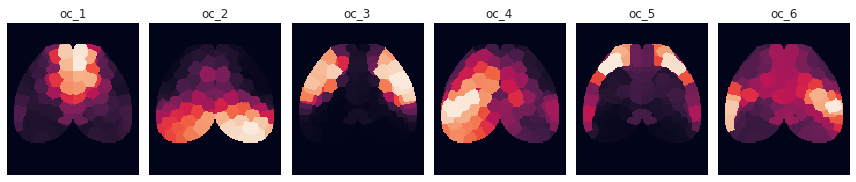

In [181]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(output['gam'], cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

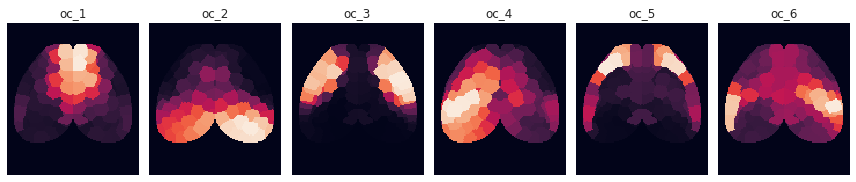

In [156]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
gam_arr = svinet.pi2arr(np.nanmean(np.nanmean(np.nanmean(pi_all, 2), 1), 0), cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

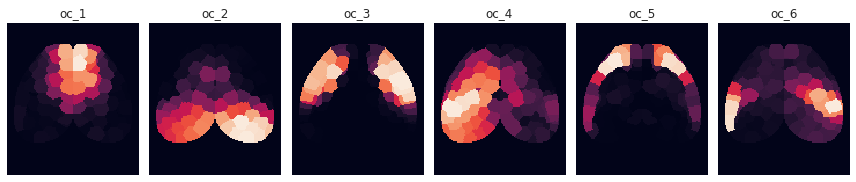

In [158]:
fig, axes = create_figure(1, k, (13.5, 4) if k == 7 else (12, 6))
_pi = np.nanmean(np.nanmean(np.nanmedian(pi_all, 2), 1), 0)
gam_arr = svinet.pi2arr(_pi, cortex_only=True)
for ax, idx in zip(axes.ravel(), range(1, k + 1)):
    im = ax.imshow(gam_arr[idx], cmap='rocket', vmin=0)
    ax.set_title(f"oc_{idx}")
remove_ticks(axes)
plt.show()

In [160]:
_pi.sum(0)

array([0.86915131, 0.80769064, 0.68585145, 0.84495132, 0.81940703,
       0.90601819, 0.51931935, 0.76145654, 0.87049879, 0.91355648,
       0.82592787, 0.93105628, 0.82785608, 0.44383345, 0.90700943,
       0.82204491, 0.90797154, 0.91123843, 0.91599848, 0.89319675,
       0.91999414, 0.48064286, 0.85699364, 0.92267711, 0.54079846,
       0.81310005, 0.91735204, 0.90612374, 0.84055286, 0.84184984,
       0.53259297, 0.84902949, 0.92199449, 0.83005686, 0.56805971,
       0.9347367 , 0.40826845, 0.72054241, 0.83684855, 0.87189922,
       0.85352341, 0.89596672, 0.64764493, 0.85300103, 0.68621972,
       0.85495402, 0.72024833, 0.90466533, 0.882262  , 0.8740084 ,
       0.72132095, 0.88900583, 0.41619105, 0.87687432, 0.83173786,
       0.91309939, 0.79673572, 0.91641008, 0.947285  , 0.90740974,
       0.90908457, 0.9276417 , 0.90378401, 0.92103114, 0.66407489,
       0.73876886, 0.70249825, 0.65218873, 0.62804428, 0.87443068,
       0.80796386, 0.68710349, 0.78768301, 0.71781665, 0.9115713 ,
       0.45040063, 0.77128924, 0.82511331, 0.90020673, 0.8354266 ,
       0.94405628, 0.70772388, 0.47309757, 0.91423153, 0.80927791,
       0.77610559, 0.88702741, 0.93279967, 0.86769451, 0.9000489 ,
       0.51304632, 0.84968047, 0.93693792, 0.57917822, 0.66766948,
       0.9460923 , 0.92544892, 0.805323  , 0.74718397, 0.53708925,
       0.7861095 , 0.9549686 , 0.87798446, 0.59320339, 0.93686589,
       0.47534892, 0.70783463, 0.68877479, 0.64919124, 0.83361853,
       0.89794165, 0.65013318, 0.68721234, 0.72926253, 0.65405101,
       0.72147567, 0.72670032, 0.75537634, 0.66468116, 0.49857777,
       0.79296444, 0.43376191, 0.72971211, 0.87515749, 0.90859919,
       0.50706726, 0.87909335, 0.93620622, 0.89373769, 0.82707355,
       0.95141635, 0.92901826, 0.92263683, 0.64463891, 0.61275215,
       0.51162872, 0.45717716, 0.44453689])

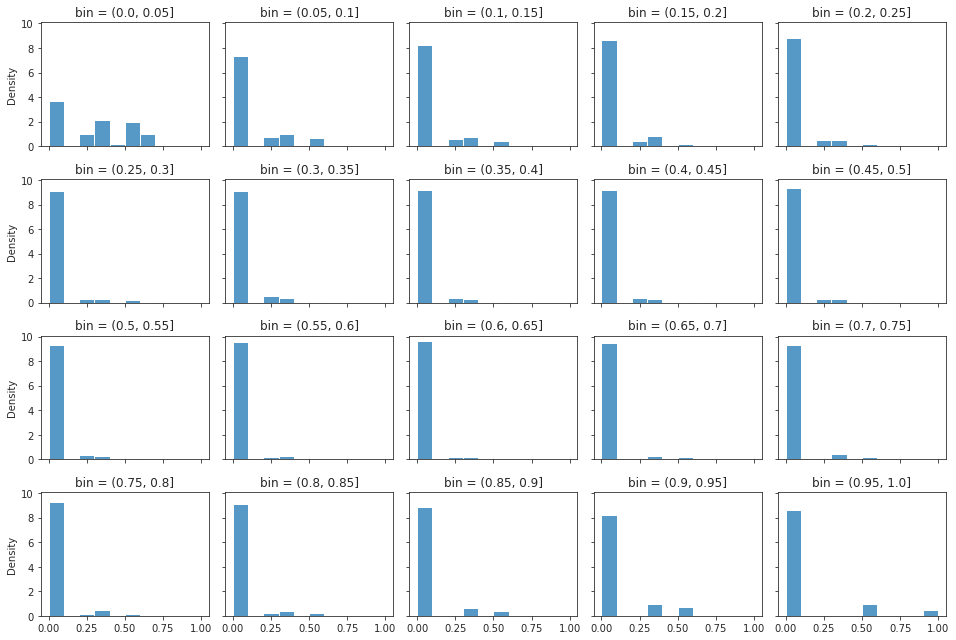

In [87]:
nrows = 4
ncols = int(np.ceil(num_cuts / nrows))
fig, axes = create_figure(nrows, ncols, (13.5, 9), 'ticks', 'all', 'all')

node = 47
for i, ax in enumerate(axes.ravel()):
    sns.histplot(pi_cut[1, 1, :, node, i], bins=np.linspace(0, 1, 11), ax=ax, stat='density')
    ax.set_title(f"bin = {intervals[i]}")

<AxesSubplot:ylabel='Count'>

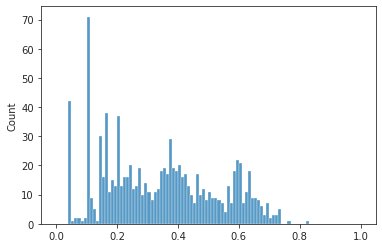

In [88]:
sns.histplot(entropies[1, 1, :, node], bins=np.linspace(0, 1, 101))

In [92]:
pd.cut([0,0,0,0,0,0,0.54,0,0,0,0.05, 0.1], np.linspace(0, 1, 11)).value_counts().values

array([2, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [36]:
data_all.dtype

dtype('float64')

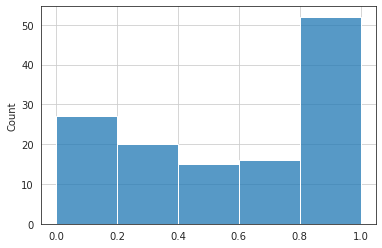

In [32]:
sns.histplot(data_all[1, 1].mean(0)[:, 4], bins=bins)
plt.grid()

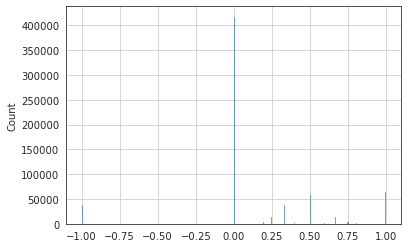

In [34]:
sns.histplot(data_all[1, 1].ravel())
plt.grid()

In [7]:
file_name = f"cut-node_bins-{num_cuts}"
save_obj(
    obj=data_all,
    file_name=file_name,
    save_dir=figs_dir,
    mode='npy',
)

[PROGRESS] 'cut-node_bins-5.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/fi
gs_combined/real-p20-k6

'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/figs_combined/real-p20-k6/cut-node_bins-5.npy'

In [22]:
nans = np.isnan(data_all).sum(2).sum(-1).astype(bool)
nans = np.where(nans)

In [23]:
nans

(
    array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4,
       4, 4, 4, 4, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 9, 9, 9, 9]),
    array([0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 1,
       1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 2,
       2, 1, 1, 1, 1]),
    array([129,  76,  76,  12,  81, 125,   6,  15,  81, 103, 108, 112, 117,
       120,  12,  81,  22,   0, 124,  34,  49,   7,  76, 135,  34,  44,
       103, 118, 103, 125,   7,  56,  81, 103,  42, 103,  34,  44,  76,
        81, 103,  44,  42,  81, 102,  38,  44, 113, 124])
)

In [24]:
pi.shape

(943, 6, 138)

In [29]:
np.where(~np.isnan(pi).sum(0).sum(0).astype(bool))[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137])

In [8]:
data_all[0, 0, ...].shape

(943, 138, 5)

<AxesSubplot:>

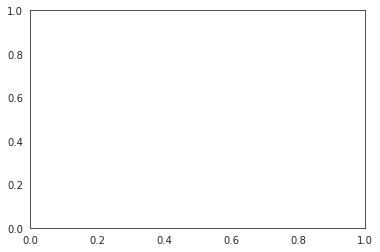

In [12]:
sns.kdeplot(data_all[0, 0, ...].mean(1)[:, 3])

In [ ]:
n_boot = int(1e4)
booted, real = bootstrap(data_all, n_boot, rng=rng)
booted, real = booted.astype(float), real.astype(float)
booted.shape